In [1]:
using DecisionMakingProblems
using MCTS
using Statistics
using Plots
using LaTeXStrings
using BenchmarkTools
using POMDPs
using POMDPModelTools
using MCTS
using POMDPSimulators
using POMDPPolicies
using BenchmarkTools
using Plots
using Statistics

In [2]:
using DecisionMakingProblems: TwentyFortyEight, isdone, get_max_rank, count_distinct_tiles, insert_tile_rand
using DecisionMakingProblems: initial_board, score_board, rollout_to_end, reward, MDP, print_board, draw_tile
using DecisionMakingProblems: init_2048_tables, move_down, move_left, move_right, move, count_empty, play_game
using DecisionMakingProblems: DIRECTIONS

In [122]:
include("./GM2048.jl")
include("./dm.jl")

Main.DM

In [4]:
mdp2048 = MDP(TwentyFortyEight(γ=0.99));

In [5]:
board2048 = initial_board();
print_board(board2048)
s = board2048; 

     0     0     0     0
     4     0     0     0
     0     0     0     0
     0     0     0     2



In [6]:
# Heuristic scoring settings
SCORE_LOST_PENALTY = 200000.0;
SCORE_MONOTONICITY_POWER = 4.0;
SCORE_MONOTONICITY_WEIGHT = 47.0;
SCORE_SUM_POWER = 3.5;
SCORE_SUM_WEIGHT = 11.0;
SCORE_MERGES_WEIGHT = 700.0;
SCORE_EMPTY_WEIGHT = 270.0;

In [7]:
get_value(board) = sum(2^power for power in GM2048.bitboard_to_array(board))
get_value(board2048)

20

In [62]:
#U6(s) = 200000 + 270 * count_empty(s) + 100* score_board(s) - 11 * get_value(s) - 10 * count_distinct_tiles(s) - score_board(s) < 2048 ? 200000 : 0

function U7(s)
    array = GM2048.bitboard_to_array(s)
    # Heuristic score
    sum = 0;
    empty::Int = 0;
    merges = 0;
    monotonicity_left = 0;
    monotonicity_right = 0;

    
    for j in 1:4
        prev = 0;
        counter = 0;
        line = array[j, :]
        for i in 1:4
            rank = line[i];
            sum += rank^SCORE_SUM_POWER;
            if rank == 0 
                empty += 1
            else 
                if (prev == rank) 
                    counter +=1
                elseif (counter > 0) 
                    merges += 1 + counter;
                    counter = 0;
                end
                prev = rank;
            end 
        end 
        
        if (counter > 0) 
            merges += 1 + counter;
        end 

        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_left += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_right += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
        
    heuristic_score = SCORE_LOST_PENALTY +
            SCORE_EMPTY_WEIGHT * empty  +
            100* score_board(s) + 
            SCORE_MERGES_WEIGHT * merges -
            #10 * count_distinct_tiles(s) - score_board(s) < 2048 ? 200000 : 0 -
            SCORE_MONOTONICITY_WEIGHT * min(monotonicity_left, monotonicity_right) -
            SCORE_SUM_WEIGHT * sum;
    return heuristic_score
end 


U7 (generic function with 1 method)

In [63]:
mcts_U7_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    50, # d
    300, # m
    50.0, # c
    s -> U7(s) # U(s) # U
);

In [66]:
mcts_2048_U6_score_policy = play_game(s -> mcts_U7_policy(s))

Move #1, current score=0.0
     0     2     0     0
     0     0     0     2
     0     0     0     0
     0     0     0     0

	a = UP
Move #2, current score=0.0
     0     2     0     2
     0     0     0     0
     2     0     0     0
     0     0     0     0

	a = LEFT
Move #3, current score=4.0
     4     0     0     0
     0     2     0     0
     2     0     0     0
     0     0     0     0

	a = DOWN
Move #4, current score=4.0
     0     2     0     0
     0     0     0     0
     4     0     0     0
     2     2     0     0

	a = LEFT
Move #5, current score=8.0
     2     0     0     0
     0     0     0     0
     4     0     0     0
     4     2     0     0

	a = UP
Move #6, current score=16.0
     2     2     0     0
     8     0     0     0
     0     2     0     0
     0     0     0     0

	a = LEFT
Move #7, current score=20.0
     4     0     0     0
     8     0     0     4
     2     0     0     0
     0     0     0     0

	a = UP
Move #8, current score=20.0
     4    

     2     0     0     0

	a = UP
Move #60, current score=504.0
    64    32    16     4
     2     8     4     0
    16     4     2     0
     2     0     2     0

	a = UP
Move #61, current score=508.0
    64    32    16     4
     2     8     4     0
    16     4     4     0
     2     0     0     2

	a = RIGHT
Move #62, current score=520.0
    64    32    16     4
     0     2     8     4
     2     0    16     8
     0     0     0     4

	a = UP
Move #63, current score=528.0
    64    32    16     8
     2     2     8     8
     0     0    16     4
     0     0     0     2

	a = UP
Move #64, current score=544.0
    64    32    16    16
     2     2     8     4
     0     2    16     2
     0     0     0     0

	a = LEFT
Move #65, current score=580.0
    64    32    32     0
     4     8     4     0
     2    16     2     0
     2     0     0     0

	a = UP
Move #66, current score=584.0
    64    32    32     0
     4     8     4     2
     4    16     2     0
     0     0     0    

    32     8     2     4
   128    64    16     8
     4    16     2     0

	a = LEFT
Move #120, current score=1276.0
    16     4     0     4
    32     8     2     4
   128    64    16     8
     4    16     2     0

	a = LEFT
Move #121, current score=1284.0
    16     8     2     0
    32     8     2     4
   128    64    16     8
     4    16     2     0

	a = DOWN
Move #122, current score=1304.0
    16     0     2     0
    32    16     4     0
   128    64    16     4
     4    16     2     8

	a = UP
Move #123, current score=1304.0
    16    16     2     4
    32    64     4     8
   128    16    16     0
     4     0     2     2

	a = LEFT
Move #124, current score=1372.0
    32     2     4     0
    32    64     4     8
   128    32     0     0
     4     4     0     2

	a = UP
Move #125, current score=1444.0
    64     2     8     8
   128    64     0     2
     4    32     0     2
     0     4     0     0

	a = DOWN
Move #126, current score=1448.0
     0     2     0     0
   

    16    32     0     0
     2     2     8     4

	a = UP
Move #179, current score=2444.0
   256    64     8     2
    64    32     0     4
    16     2     0     0
     2     2     0     0

	a = UP
Move #180, current score=2448.0
   256    64     8     2
    64    32     0     4
    16     4     4     0
     2     0     0     0

	a = UP
Move #181, current score=2448.0
   256    64     8     2
    64    32     4     4
    16     4     0     0
     2     2     0     0

	a = DOWN
Move #182, current score=2448.0
   256    64     0     0
    64    32     2     0
    16     4     8     2
     2     2     4     4

	a = UP
Move #183, current score=2448.0
   256    64     2     2
    64    32     8     4
    16     4     4     0
     2     2     2     0

	a = LEFT
Move #184, current score=2464.0
   256    64     4     0
    64    32     8     4
    16     8     0     0
     4     2     2     0

	a = DOWN
Move #185, current score=2464.0
   256    64     0     2
    64    32     4     0
    16 

	a = UP
Move #237, current score=3100.0
   256    64    32    16
   128    32    16     8
     2    16     2     8
     2     0     0     0

	a = UP
Move #238, current score=3120.0
   256    64    32    16
   128    32    16    16
     4    16     2     0
     0     4     0     0

	a = LEFT
Move #239, current score=3152.0
   256    64    32    16
   128    32    32     0
     4    16     2     2
     4     0     0     0

	a = LEFT
Move #240, current score=3220.0
   256    64    32    16
   128    64     4     0
     4    16     4     0
     4     0     0     0

	a = DOWN
Move #241, current score=3364.0
     2     0     0     0
   256     0     0     0
   128   128    32     0
     8    16     8    16

	a = LEFT
Move #242, current score=3620.0
     2     0     2     0
   256     0     0     0
   256    32     0     0
     8    16     8    16

	a = DOWN
Move #243, current score=4132.0
     0     2     0     0
     2     0     0     0
   512    32     2     0
     8    16     8    16

	a 

     4     8     4     0

	a = DOWN
Move #296, current score=4784.0
     4     4     8     2
     2    16    16     2
   512   128     2    16
     4     8     4     4

	a = LEFT
Move #297, current score=4832.0
     8     8     2     2
     2    32     2     0
   512   128     2    16
     4     8     8     0

	a = DOWN
Move #298, current score=4836.0
     8     8     2     0
     2    32     2     0
   512   128     4     2
     4     8     8    16

	a = DOWN
Move #299, current score=4840.0
     8     8     2     0
     2    32     4     0
   512   128     4     2
     4     8     8    16

	a = DOWN
Move #300, current score=4848.0
     8     8     4     0
     2    32     2     0
   512   128     8     2
     4     8     8    16

	a = RIGHT
Move #301, current score=4880.0
     2     0    16     4
     0     2    32     2
   512   128     8     2
     0     4    16    16

	a = UP
Move #302, current score=4884.0
     2     2    16     4
   512   128    32     4
     0     4     8    16


   512   128    64     4
     4    32     8     4
    64     8     4     4

	a = LEFT
Move #354, current score=5444.0
     2    16     2     0
   512   128    64     4
     4    32     8     4
    64     8     8     4

	a = LEFT
Move #355, current score=5460.0
     2    16     2     0
   512   128    64     4
     4    32     8     4
    64    16     4     2

	a = DOWN
Move #356, current score=5468.0
     2    16     2     4
   512   128    64     0
     4    32     8     8
    64    16     4     2

	a = LEFT
Move #357, current score=5484.0
     2    16     2     4
   512   128    64     0
     4    32    16     2
    64    16     4     2

	a = DOWN
Move #358, current score=5488.0
     2    16     2     2
   512   128    64     0
     4    32    16     4
    64    16     4     4

	a = UP
Move #359, current score=5496.0
     2    16     2     2
   512   128    64     8
     4    32    16     2
    64    16     4     0

	a = DOWN
     2    16     2     4
   512   128    64     2
     4  

In [67]:
rollouts_mcts_U7 = [ DM.rollout(mdp2048, initial_board(), mcts_U7_policy, 1000, isdone) for i in 1:100 ]

100-element Vector{Float64}:
 1271.5687401067391
 1218.733625034419
 1137.9798566421698
 1034.4342793030746
  947.6391583999962
  706.6426004826096
  373.7226311990474
  698.8512147607836
  778.2723703416125
 1048.814368089995
 1108.3297981084263
  544.2781535079738
  721.4980890895679
    ⋮
 1245.8347693402493
  510.0070705512978
  325.7612440808941
 1027.9324696350975
  946.8331178716428
  334.4620171110683
  688.8241920675342
  206.98836246122323
  333.74660250765544
 1053.7665561279753
  602.8112540992987
 1040.2743680847761

In [68]:
print("mcts_2048_U7: $(mean(rollouts_mcts_U7)) ± $(std(rollouts_mcts_U7))")

mcts_2048_U7: 809.4147210820291 ± 316.69764150855025

In [11]:
function U8(s)
    smoothWeight = 0.1;
    mono2Weight  = 1.0;
    emptyWeight  = 2.7;
    maxWeight    = 1.0;

    array = GM2048.bitboard_to_array(s)
    # Heuristic score
    sum = 0;
    empty::Int = 0;
    merges = 0;
    monotonicity_left = 0;
    monotonicity_right = 0;

    
    for j in 1:4
        prev = 0;
        counter = 0;
        line = array[j, :]
        for i in 1:4
            rank = line[i];
            sum += rank^SCORE_SUM_POWER;
            if rank == 0 
                empty += 1
            else 
                if (prev == rank) 
                    counter +=1
                elseif (counter > 0) 
                    merges += 1 + counter;
                    counter = 0;
                end
                prev = rank;
            end 
        end 
        
        if (counter > 0) 
            merges += 1 + counter;
        end 

        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_left += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_right += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
    
    smoothness = merges
    heuristic_score = 
        smoothness * smoothWeight
       + max(monotonicity_left, monotonicity_right) * mono2Weight
       + log(empty) * emptyWeight
       + score_board(s) * maxWeight
    return heuristic_score
end 

U8 (generic function with 1 method)

In [12]:
mcts_U8_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    50, # d
    300, # m
    50.0, # c
    s -> U8(s) # U(s) # U
);

In [95]:
mcts_2048_game_U8_policy = play_game(s -> mcts_U8_policy(s))

Move #1, current score=0.0
     2     0     0     0
     0     0     0     0
     0     2     0     0
     0     0     0     0

	a = UP
Move #2, current score=0.0
     2     2     0     0
     0     0     0     0
     0     0     0     2
     0     0     0     0

	a = LEFT
Move #3, current score=4.0
     4     0     0     0
     4     0     0     0
     2     0     0     0
     0     0     0     0

	a = UP
Move #4, current score=12.0
     8     0     0     0
     2     0     2     0
     0     0     0     0
     0     0     0     0

	a = RIGHT
Move #5, current score=16.0
     0     0     0     8
     0     0     0     4
     0     0     0     0
     0     0     0     2

	a = LEFT
Move #6, current score=16.0
     8     0     0     0
     4     2     0     0
     0     0     0     0
     2     0     0     0

	a = RIGHT
Move #7, current score=16.0
     0     0     0     8
     0     2     4     2
     0     0     0     0
     0     0     0     2

	a = DOWN
Move #8, current score=20.0
    

	a = UP
Move #61, current score=616.0
     0     2    64     8
     0     0     0     2
     0     0     4    64
     0     0     0     4

	a = DOWN
Move #62, current score=616.0
     0     2     0     8
     0     0     0     2
     0     0    64    64
     0     2     4     4

	a = LEFT
Move #63, current score=752.0
     2     8     0     0
     2     0     0     0
   128     0     0     2
     2     8     0     0

	a = UP
Move #64, current score=772.0
     4    16     0     2
   128     0     0     0
     2     0     0     0
     2     0     0     0

	a = UP
Move #65, current score=776.0
     4    16     0     2
   128     0     0     0
     4     0     0     0
     0     4     0     0

	a = LEFT
Move #66, current score=776.0
     4    16     2     0
   128     0     0     0
     4     0     0     0
     4     0     0     2

	a = DOWN
Move #67, current score=784.0
     0     0     0     0
     4     0     2     0
   128     0     0     0
     8    16     2     2

	a = RIGHT
Move #68

	a = DOWN
Move #119, current score=1368.0
     0     0     2     4
     0     0    64    16
     0     0     4    64
     2     2   128     2

	a = LEFT
Move #120, current score=1372.0
     2     4     0     2
    64    16     0     0
     4    64     0     0
     4   128     2     0

	a = DOWN
Move #121, current score=1380.0
     0     4     2     0
     2    16     0     0
    64    64     0     0
     8   128     2     2

	a = RIGHT
Move #122, current score=1512.0
     0     0     4     2
     0     0     2    16
     0     0     2   128
     0     8   128     4

	a = UP
Move #123, current score=1516.0
     0     8     4     2
     0     0     4    16
     2     0   128   128
     0     0     0     4

	a = RIGHT
Move #124, current score=1772.0
     0     8     4     2
     0     0     4    16
     0     0     2   256
     0     0     2     4

	a = UP
Move #125, current score=1784.0
     0     8     8     2
     0     0     4    16
     2     0     0   256
     0     0     0     4

	

	a = RIGHT
Move #177, current score=2316.0
     0     0     0     2
     0     0     8    32
     0     2    64   256
     4     8    32    16

	a = LEFT
Move #178, current score=2316.0
     2     0     4     0
     8    32     0     0
     2    64   256     0
     4     8    32    16

	a = RIGHT
Move #179, current score=2316.0
     0     0     2     4
     0     2     8    32
     0     2    64   256
     4     8    32    16

	a = UP
Move #180, current score=2320.0
     4     4     2     4
     0     8     8    32
     0     0    64   256
     2     0    32    16

	a = RIGHT
Move #181, current score=2344.0
     2     8     2     4
     0     0    16    32
     0     0    64   256
     0     2    32    16

	a = DOWN
Move #182, current score=2344.0
     0     0     2     4
     0     0    16    32
     2     8    64   256
     2     2    32    16

	a = RIGHT
Move #183, current score=2348.0
     0     0     2     4
     2     0    16    32
     2     8    64   256
     0     4    32    1

     2     8    64     8
     4    32   128     8
     8   256     4    32

	a = UP
Move #235, current score=3056.0
     4     8    64    16
     4    32   128    32
     8   256     4     0
     0     4     0     0

	a = UP
Move #236, current score=3064.0
     8     8    64    16
     8    32   128    32
     0   256     4     0
     2     4     0     0

	a = RIGHT
Move #237, current score=3080.0
     0    16    64    16
     8    32   128    32
     2     0   256     4
     0     0     2     4

	a = UP
Move #238, current score=3088.0
     8    16    64    16
     2    32   128    32
     0     0   256     8
     2     0     2     0

	a = UP
Move #239, current score=3092.0
     8    16    64    16
     4    32   128    32
     2     0   256     8
     0     0     2     0

	a = LEFT
Move #240, current score=3092.0
     8    16    64    16
     4    32   128    32
     2   256     8     0
     2     2     0     0

	a = UP
Move #241, current score=3096.0
     8    16    64    16
     4  

	a = LEFT
Move #292, current score=4752.0
    16     4     8     0
     4   512     2     0
   128     8     0     0
     2     0     0     2

	a = DOWN
Move #293, current score=4752.0
    16     2     0     0
     4     4     0     0
   128   512     8     0
     2     8     2     2

	a = RIGHT
Move #294, current score=4764.0
     0     0    16     2
     0     2     0     8
     0   128   512     8
     0     2     8     4

	a = UP
Move #295, current score=4780.0
     0     2    16     2
     2   128   512    16
     0     2     8     4
     0     0     0     0

	a = UP
Move #296, current score=4780.0
     2     2    16     2
     0   128   512    16
     0     2     8     4
     0     0     0     2

	a = DOWN
Move #297, current score=4780.0
     0     0     0     2
     0     2    16    16
     2   128   512     4
     2     2     8     2

	a = RIGHT
Move #298, current score=4816.0
     0     2     0     2
     0     0     2    32
     2   128   512     4
     0     4     8     2

	

	a = DOWN
Move #350, current score=5496.0
     0     0     8     0
     2     0    16     2
     0   128   128     8
     4   512     2     4

	a = LEFT
Move #351, current score=5752.0
     8     0     0     0
     2    16     2     2
   256     8     0     0
     4   512     2     4

	a = DOWN
Move #352, current score=5756.0
     8     0     0     0
     2    16     0     4
   256     8     0     2
     4   512     4     4

	a = RIGHT
Move #353, current score=5764.0
     0     0     4     8
     0     2    16     4
     0   256     8     2
     0     4   512     8

	a = LEFT
Move #354, current score=5764.0
     4     8     0     0
     2    16     4     2
   256     8     2     0
     4   512     8     0

	a = UP
Move #355, current score=5764.0
     4     8     4     2
     2    16     2     2
   256     8     8     0
     4   512     0     0

	a = LEFT
Move #356, current score=5784.0
     4     8     4     2
     2    16     4     2
   256    16     0     0
     4   512     0     0




	a = UP
Move #408, current score=6496.0
     2     2   128   256
     0    16     8     8
     2     4     0   512
     0     0     0     4

	a = RIGHT
Move #409, current score=6516.0
     0     4   128   256
     2     0    16    16
     0     2     4   512
     0     0     0     4

	a = LEFT
Move #410, current score=6548.0
     4   128   256     0
     2    32     0     0
     2     4   512     0
     4     0     2     0

	a = DOWN
Move #411, current score=6552.0
     0     2     0     0
     4   128   256     0
     4    32   512     0
     4     4     2     0

	a = RIGHT
Move #412, current score=6560.0
     0     0     0     2
     4     4   128   256
     0     4    32   512
     0     0     8     2

	a = DOWN
Move #413, current score=6568.0
     0     0     0     2
     2     0   128   256
     0     0    32   512
     4     8     8     2

	a = LEFT
Move #414, current score=6584.0
     2     0     0     0
     2   128   256     0
    32   512     0     4
     4    16     2     0

     2     8  1024     0

	a = UP
Move #466, current score=9080.0
    32     4     2     2
     2     8  1024     0
     0     0     0     0
     2     0     0     0

	a = LEFT
Move #467, current score=9084.0
    32     4     4     0
     2     8  1024     0
     0     2     0     0
     2     0     0     0

	a = LEFT
Move #468, current score=9092.0
    32     8     0     0
     2     8  1024     0
     2     0     0     0
     2     0     0     2

	a = UP
Move #469, current score=9112.0
    32    16  1024     2
     4     0     0     0
     2     0     2     0
     0     0     0     0

	a = LEFT
Move #470, current score=9116.0
    32    16  1024     2
     4     0     0     0
     4     0     0     0
     0     0     0     2

	a = UP
Move #471, current score=9128.0
    32    16  1024     4
     8     0     0     0
     0     0     2     0
     0     0     0     0

	a = UP
Move #472, current score=9128.0
    32    16  1024     4
     8     0     2     0
     0     2     0     0
     0 

     4    32     0     0

	a = UP
Move #524, current score=9848.0
     2    16     2     2
   128  1024     0     0
     8    32     0     0
     0     0     0     0

	a = RIGHT
Move #525, current score=9852.0
     0     2    16     4
     0     0   128  1024
     0     0     8    32
     0     2     0     0

	a = UP
Move #526, current score=9856.0
     0     4    16     4
     0     0   128  1024
     0     0     8    32
     0     2     0     0

	a = RIGHT
Move #527, current score=9856.0
     0     4    16     4
     2     0   128  1024
     0     0     8    32
     0     0     0     2

	a = UP
Move #528, current score=9856.0
     2     4    16     4
     2     0   128  1024
     0     0     8    32
     0     0     0     2

	a = DOWN
Move #529, current score=9860.0
     0     0     4     4
     0     0    16  1024
     0     0   128    32
     4     4     8     2

	a = LEFT
Move #530, current score=9876.0
     8     0     0     0
    16  1024     0     0
   128    32     0     4
   

	a = LEFT
Move #638, current score=11592.0
     8     4     4     0
    16   256    16     2
     2  1024   128     0
    32     0     2     0

	a = RIGHT
Move #639, current score=11600.0
     0     0     8     8
    16   256    16     2
     0     2  1024   128
     0     2    32     2

	a = LEFT
Move #640, current score=11616.0
    16     2     0     0
    16   256    16     2
     2  1024   128     0
     2    32     2     0

	a = DOWN
Move #641, current score=11652.0
     0     2     0     2
     0   256    16     0
    32  1024   128     0
     4    32     2     2

	a = LEFT
Move #642, current score=11660.0
     4     0     0     0
   256    16     0     0
    32  1024   128     0
     4    32     4     2

	a = UP
Move #643, current score=11660.0
     4    16   128     2
   256  1024     4     0
    32    32     0     0
     4     0     2     0

	a = LEFT
Move #644, current score=11724.0
     4    16   128     2
   256  1024     4     0
    64     0     0     2
     4     2     0 

    32   128    32     8
     4     2  1024     2
     0     0     0     0

	a = DOWN
Move #753, current score=13872.0
     0     0     0     2
     8   512     4     2
    32   128    32     8
     4     2  1024     2

	a = UP
Move #754, current score=13876.0
     8   512     4     4
    32   128    32     8
     4     2  1024     2
     0     0     0     2

	a = RIGHT
Move #755, current score=13884.0
     0     8   512     8
    32   128    32     8
     4     2  1024     2
     0     2     0     2

	a = DOWN
Move #756, current score=13908.0
     0     2     0     0
     0     8   512     0
    32   128    32    16
     4     4  1024     4

	a = RIGHT
Move #757, current score=13916.0
     0     0     0     2
     0     0     8   512
    32   128    32    16
     2     8  1024     4

	a = UP
Move #758, current score=13916.0
    32   128     8     2
     2     8    32   512
     0     0  1024    16
     0     4     0     4

	a = RIGHT
Move #759, current score=13924.0
    32   128     8

     4    32  1024   256

	a = DOWN
Move #810, current score=15000.0
     0     0     2     0
     0     0     2     2
     2     0   512    64
     4    32  1024   256

	a = RIGHT
Move #811, current score=15004.0
     2     0     0     2
     0     0     0     4
     0     2   512    64
     4    32  1024   256

	a = RIGHT
Move #812, current score=15008.0
     0     0     0     4
     0     0     0     4
     2     2   512    64
     4    32  1024   256

	a = LEFT
Move #813, current score=15012.0
     4     0     0     0
     4     0     0     0
     4   512    64     2
     4    32  1024   256

	a = DOWN
Move #814, current score=15028.0
     0     0     0     0
     0     0     4     0
     8   512    64     2
     8    32  1024   256

	a = DOWN
Move #815, current score=15044.0
     0     0     0     0
     2     0     4     0
     0   512    64     2
    16    32  1024   256

	a = RIGHT
Move #816, current score=15044.0
     0     0     0     0
     4     0     2     4
     0   512  

     2  1024   512    16
     2     4     8   256

	a = DOWN
Move #868, current score=15716.0
     0     0   128     2
     0    16    64     8
     2  1024   512    16
     4     4     8   256

	a = LEFT
Move #869, current score=15724.0
   128     2     0     0
    16    64     8     4
     2  1024   512    16
     8     8   256     0

	a = RIGHT
Move #870, current score=15740.0
     4     0   128     2
    16    64     8     4
     2  1024   512    16
     0     0    16   256

	a = UP
Move #871, current score=15740.0
     4    64   128     2
    16  1024     8     4
     2     0   512    16
     0     2    16   256

	a = LEFT
Move #872, current score=15740.0
     4    64   128     2
    16  1024     8     4
     2   512    16     2
     2    16   256     0

	a = RIGHT
Move #873, current score=15740.0
     4    64   128     2
    16  1024     8     4
     2   512    16     2
     2     2    16   256

	a = UP
Move #874, current score=15776.0
     4    64   128     2
    16  1024     8 

In [78]:
mcts_2048_game_U8_policy2 = play_game(s -> mcts_U8_policy(s))

Move #1, current score=0.0
     4     0     0     0
     0     0     0     2
     0     0     0     0
     0     0     0     0

	a = RIGHT
Move #2, current score=0.0
     2     0     0     4
     0     0     0     2
     0     0     0     0
     0     0     0     0

	a = LEFT
Move #3, current score=0.0
     2     4     0     0
     2     0     0     0
     2     0     0     0
     0     0     0     0

	a = DOWN
Move #4, current score=4.0
     0     0     0     0
     0     0     0     0
     2     0     0     2
     4     4     0     0

	a = RIGHT
Move #5, current score=16.0
     0     0     0     0
     0     0     2     0
     0     0     0     4
     0     0     0     8

	a = DOWN
Move #6, current score=16.0
     0     0     0     0
     0     0     0     2
     0     0     0     4
     0     0     2     8

	a = UP
Move #7, current score=16.0
     0     0     2     2
     0     0     0     4
     0     0     0     8
     2     0     0     0

	a = RIGHT
Move #8, current score=20.0
  


	a = UP
Move #60, current score=516.0
     2     8    16     4
     0     0    64    32
     0     2    16     2
     0     0     0     0

	a = LEFT
Move #61, current score=516.0
     2     8    16     4
    64    32     0     0
     2    16     2     0
     0     0     0     4

	a = UP
Move #62, current score=524.0
     2     8    16     8
    64    32     2     0
     2    16     0     2
     0     0     0     0

	a = RIGHT
Move #63, current score=524.0
     2     8    16     8
     0    64    32     2
     4     2    16     2
     0     0     0     0

	a = UP
Move #64, current score=528.0
     2     8    16     8
     4    64    32     4
     0     2    16     0
     0     2     0     0

	a = DOWN
Move #65, current score=532.0
     2     0     0     0
     0     8    16     0
     2    64    32     8
     4     4    16     4

	a = DOWN
Move #66, current score=536.0
     2     0     0     0
     0     8    16     0
     4    64    32     8
     4     4    16     4

	a = RIGHT
Move #

     4     2     4     0
     4    32   128    32
     4     2    64     8

	a = DOWN
Move #119, current score=1292.0
     0     2     0     0
     0     2     4     0
     4    32   128    32
     8     2    64     8

	a = UP
Move #120, current score=1296.0
     4     4     4    32
     8    32   128     8
     0     2    64     0
     0     0     0     2

	a = LEFT
Move #121, current score=1304.0
     8     4    32     2
     8    32   128     8
     2    64     0     0
     2     0     0     0

	a = DOWN
Move #122, current score=1324.0
     0     0     0     0
     4     4     0     0
    16    32    32     2
     4    64   128     8

	a = LEFT
Move #123, current score=1396.0
     0     0     0     0
     8     2     0     0
    16    64     2     0
     4    64   128     8

	a = DOWN
Move #124, current score=1524.0
     0     0     0     0
     8     0     0     0
    16     2     2     4
     4   128   128     8

	a = RIGHT
Move #125, current score=1784.0
     2     0     0     0



	a = LEFT
Move #176, current score=2336.0
     2     4     0     0
     2   256     2     2
     8     2     4    64
     2    64     4     0

	a = UP
Move #177, current score=2348.0
     4     4     2     2
     8   256     8    64
     2     2     0     2
     0    64     0     0

	a = LEFT
Move #178, current score=2364.0
     8     4     2     0
     8   256     8    64
     4     2     0     0
    64     0     0     0

	a = DOWN
Move #179, current score=2380.0
     0     0     0     0
    16     4     4     0
     4   256     2     0
    64     2     8    64

	a = RIGHT
Move #180, current score=2388.0
     0     0     0     2
     0     0    16     8
     0     4   256     2
    64     2     8    64

	a = LEFT
Move #181, current score=2388.0
     2     0     4     0
    16     8     0     0
     4   256     2     0
    64     2     8    64

	a = LEFT
Move #182, current score=2388.0
     2     4     0     4
    16     8     0     0
     4   256     2     0
    64     2     8    64


     0     4    32    16

	a = DOWN
Move #234, current score=3068.0
     0     0     0     4
     0     2    64    32
     0    16   256   128
     4     4    32    16

	a = RIGHT
Move #235, current score=3076.0
     0     0     0     4
     2     2    64    32
     0    16   256   128
     0     8    32    16

	a = LEFT
Move #236, current score=3080.0
     4     2     0     0
     4    64    32     0
    16   256   128     0
     8    32    16     0

	a = DOWN
Move #237, current score=3088.0
     0     2     0     0
     8    64    32     0
    16   256   128     0
     8    32    16     2

	a = UP
Move #238, current score=3088.0
     8     2    32     2
    16    64   128     0
     8   256    16     0
     0    32     0     2

	a = LEFT
Move #239, current score=3088.0
     8     2    32     2
    16    64   128     0
     8   256    16     0
    32     2     2     0

	a = DOWN
Move #240, current score=3088.0
     8     2    32     0
    16    64   128     2
     8   256    16     0



	a = UP
Move #293, current score=4800.0
     4     4     2     4
     8    32   128     0
   512     0     0     0
     2     0     0     2

	a = RIGHT
Move #294, current score=4812.0
     0     8     2     4
     0     8    32   128
     0     2     0   512
     0     0     0     4

	a = DOWN
Move #295, current score=4828.0
     0     0     2     4
     0     0     0   128
     0    16     2   512
     0     2    32     4

	a = UP
Move #296, current score=4832.0
     0    16     4     4
     0     2    32   128
     0     0     0   512
     0     0     2     4

	a = RIGHT
Move #297, current score=4840.0
     0     0    16     8
     0     2    32   128
     0     0     0   512
     0     4     2     4

	a = UP
Move #298, current score=4840.0
     0     2    16     8
     0     4    32   128
     0     0     2   512
     2     0     0     4

	a = RIGHT
Move #299, current score=4840.0
     0     2    16     8
     2     4    32   128
     0     0     2   512
     0     0     2     4

	


	a = DOWN
Move #351, current score=5804.0
     4     0     2     0
     8     0     8     0
   512     2   256     0
     2    32     2     0

	a = LEFT
Move #352, current score=5820.0
     4     2     2     0
    16     0     0     0
   512     2   256     0
     2    32     2     0

	a = UP
Move #353, current score=5824.0
     4     4     2     0
    16    32   256     0
   512     4     2     0
     2     0     0     0

	a = RIGHT
Move #354, current score=5832.0
     4     0     8     2
     0    16    32   256
     0   512     4     2
     0     0     0     2

	a = DOWN
Move #355, current score=5836.0
     0     0     0     0
     0     0     8     2
     4    16    32   256
     4   512     4     4

	a = LEFT
Move #356, current score=5844.0
     2     0     0     0
     8     2     0     0
     4    16    32   256
     4   512     8     0

	a = DOWN
Move #357, current score=5852.0
     0     0     4     0
     2     2     0     0
     8    16    32     0
     8   512     8   256


     2     8   256     8
     0    32   128     2
     4   512     4     8

	a = LEFT
Move #410, current score=6548.0
     4     2     0     0
     2     8   256     8
    32   128     2     0
     4   512     4     8

	a = UP
Move #411, current score=6564.0
     4     2   256    16
     2     8     2     0
    32   128     4     0
     4   512     0     2

	a = RIGHT
Move #412, current score=6564.0
     4     2   256    16
     2     2     8     2
     0    32   128     4
     0     4   512     2

	a = LEFT
Move #413, current score=6568.0
     4     2   256    16
     4     8     2     0
    32   128     4     0
     4   512     2     4

	a = DOWN
Move #414, current score=6576.0
     2     2   256     0
     8     8     2     0
    32   128     4    16
     4   512     2     4

	a = UP
Move #415, current score=6576.0
     2     2   256    16
     8     8     2     4
    32   128     4     2
     4   512     2     0

	a = RIGHT
Move #416, current score=6596.0
     0     4   256    16
 

	a = LEFT
Move #468, current score=7576.0
     4     0     0     4
    16   256     2     0
     4   256    32   512
     4     2     4    16

	a = DOWN
Move #469, current score=8096.0
     0     0     0     2
     4     0     2     4
    16   512    32   512
     8     2     4    16

	a = RIGHT
Move #470, current score=8096.0
     4     0     0     2
     0     4     2     4
    16   512    32   512
     8     2     4    16

	a = LEFT
Move #471, current score=8096.0
     4     2     2     0
     4     2     4     0
    16   512    32   512
     8     2     4    16

	a = DOWN
Move #472, current score=8108.0
     2     0     2     0
     8     4     4     0
    16   512    32   512
     8     2     4    16

	a = LEFT
Move #473, current score=8120.0
     4     2     0     0
     8     8     0     0
    16   512    32   512
     8     2     4    16

	a = LEFT
Move #474, current score=8136.0
     4     2     0     0
    16     0     4     0
    16   512    32   512
     8     2     4    16

  1024   128     2     0
    64     8     0     2
     2     4     0     0

	a = LEFT
Move #526, current score=9956.0
     2     8     8     0
  1024   128     2     0
    64     8     2     0
     2     4     0     2

	a = DOWN
Move #527, current score=9960.0
     2     8     0     0
  1024   128     2     0
    64     8     8     0
     2     4     4     2

	a = RIGHT
Move #528, current score=9984.0
     0     0     2     8
     0  1024   128     2
     4     0    64    16
     0     2     8     2

	a = UP
Move #529, current score=9984.0
     4  1024     2     8
     0     2   128     2
     0     0    64    16
     0     2     8     2

	a = DOWN
Move #530, current score=9988.0
     4     0     2     8
     0     0   128     2
     0  1024    64    16
     4     4     8     2

	a = LEFT
Move #531, current score=9996.0
     4     2     8     0
   128     2     2     0
  1024    64    16     0
     8     8     2     0

	a = RIGHT
Move #532, current score=10016.0
     0     4     2     

	a = UP
Move #584, current score=10996.0
     8    16    64  1024
     2     2     2   256
     0    16     2     8
     0     0     0     0

	a = UP
Move #585, current score=11000.0
     8    16    64  1024
     2     2     4   256
     0    16     0     8
     0     2     0     0

	a = RIGHT
Move #586, current score=11004.0
     8    16    64  1024
     0     4     4   256
     0     4    16     8
     0     0     0     2

	a = DOWN
Move #587, current score=11012.0
     0     0     2  1024
     0     0    64   256
     0    16     4     8
     8     8    16     2

	a = LEFT
Move #588, current score=11028.0
     2  1024     0     0
    64   256     0     4
    16     4     8     0
    16    16     2     0

	a = UP
Move #589, current score=11060.0
     2  1024     8     4
    64   256     2     0
    32     4     0     0
     2    16     0     0

	a = RIGHT
Move #590, current score=11060.0
     2  1024     8     4
     0    64   256     2
     0     0    32     4
     0     4     2    

	a = RIGHT
Move #642, current score=11784.0
     4     2    64    16
     4  1024   128     8
     0     2     8   256
     0     0     2    32

	a = LEFT
Move #643, current score=11784.0
     4     2    64    16
     4  1024   128     8
     2     8   256     0
     2    32     2     0

	a = DOWN
Move #644, current score=11796.0
     0     2    64     0
     2  1024   128     0
     8     8   256    16
     4    32     2     8

	a = RIGHT
Move #645, current score=11812.0
     0     0     2    64
     2     2  1024   128
     0    16   256    16
     4    32     2     8

	a = UP
Move #646, current score=11812.0
     2     2     2    64
     4    16  1024   128
     0    32   256    16
     0     4     2     8

	a = DOWN
Move #647, current score=11812.0
     0     2     2    64
     4    16  1024   128
     2    32   256    16
     4     4     2     8

	a = LEFT
Move #648, current score=11824.0
     4    64     0     2
     4    16  1024   128
     2    32   256    16
     8     2     8

    16     2   512     4
     0     0  1024    64
     2     0    32     8

	a = LEFT
Move #700, current score=13332.0
    16    16     0     0
    16     2   512     4
  1024    64     2     0
     2    32     8     0

	a = UP
Move #701, current score=13364.0
    32    16   512     4
  1024     2     2     0
     2    64     8     0
     2    32     0     0

	a = RIGHT
Move #702, current score=13368.0
    32    16   512     4
     0     0  1024     4
     0     2    64     8
     0     4     2    32

	a = UP
Move #703, current score=13376.0
    32    16   512     8
     0     2  1024     8
     0     4    64    32
     0     4     2     0

	a = UP
Move #704, current score=13400.0
    32    16   512    16
     0     2  1024    32
     0     8    64     0
     2     0     2     0

	a = UP
Move #705, current score=13400.0
    32    16   512    16
     2     2  1024    32
     0     8    64     0
     0     0     2     2

	a = RIGHT
Move #706, current score=13408.0
    32    16   512    1

     8    64     2     0
     2  1024   512    16
     4     8    64     8

	a = RIGHT
Move #757, current score=14164.0
     2     0   128     2
     0     8    64     2
     2  1024   512    16
     4     8    64     8

	a = DOWN
Move #758, current score=14172.0
     2     0   128     0
     0     8    64     4
     4  1024   512    16
     4     8    64     8

	a = DOWN
Move #759, current score=14180.0
     0     0   128     2
     0     8    64     4
     2  1024   512    16
     8     8    64     8

	a = RIGHT
Move #760, current score=14196.0
     0     0   128     2
     4     8    64     4
     2  1024   512    16
     0    16    64     8

	a = LEFT
Move #761, current score=14196.0
   128     2     0     2
     4     8    64     4
     2  1024   512    16
    16    64     8     0

	a = RIGHT
Move #762, current score=14200.0
     0     2   128     4
     4     8    64     4
     2  1024   512    16
     0    16    64     8

	a = UP
Move #763, current score=14208.0
     4     2   1

   512    16  1024     2
     0     4    16    64

	a = UP
Move #816, current score=15228.0
     2    32     2    64
   512     4   256     4
     0     4  1024     2
     0     0    16    64

	a = DOWN
Move #817, current score=15236.0
     2     0     2    64
     0     0   256     4
     2    32  1024     2
   512     8    16    64

	a = RIGHT
Move #818, current score=15240.0
     2     0     4    64
     0     0   256     4
     2    32  1024     2
   512     8    16    64

	a = LEFT
Move #819, current score=15240.0
     2     4    64     0
   256     4     0     2
     2    32  1024     2
   512     8    16    64

	a = DOWN
Move #820, current score=15252.0
     2     4     0     0
   256     8    64     0
     2    32  1024     4
   512     8    16    64

	a = RIGHT
Move #821, current score=15252.0
     2     0     2     4
     0   256     8    64
     2    32  1024     4
   512     8    16    64

	a = LEFT
Move #822, current score=15256.0
     4     4     0     2
   256     8    6


	a = UP
Move #874, current score=16056.0
     2     8   128     8
    16   256  1024    16
     2   512   128     4
     2     4     8     0

	a = DOWN
Move #875, current score=16060.0
     4     8   128     0
     2   256  1024     8
    16   512   128    16
     4     4     8     4

	a = LEFT
Move #876, current score=16068.0
     4     8   128     0
     2   256  1024     8
    16   512   128    16
     8     8     4     2

	a = LEFT
Move #877, current score=16084.0
     4     8   128     2
     2   256  1024     8
    16   512   128    16
    16     4     2     0

	a = DOWN
Move #878, current score=16116.0
     2     8   128     0
     4   256  1024     2
     2   512   128     8
    32     4     2    16

	a = RIGHT
Move #879, current score=16116.0
     2     2     8   128
     4   256  1024     2
     2   512   128     8
    32     4     2    16

	a = LEFT
Move #880, current score=16120.0
     4     8   128     2
     4   256  1024     2
     2   512   128     8
    32     4     2

In [81]:
rollouts_mcts_U8s = [ DM.rollout(mdp2048, initial_board(), mcts_U8_policy, 10000, isdone) for i in 1]

0-dimensional Array{Float64, 0}:
1409.5619165219

In [8]:
function U9(s)
    smoothWeight = 0.1;
    mono2Weight  = 1.0;
    emptyWeight  = 2.7;
    maxWeight    = 2.0;

    array = GM2048.bitboard_to_array(s)
    # Heuristic score
    sum = 0;
    empty::Int = 0;
    merges = 0;
    monotonicity_left = 0;
    monotonicity_right = 0;
    monotonicity_up = 0;
    monotonicity_down = 0;

    
    for j in 1:4
        prev = 0;
        counter = 0;
        line = array[j, :]
        for i in 1:4
            rank = line[i];
            sum += rank^SCORE_SUM_POWER;
            if rank == 0 
                empty += 1
            else 
                if (prev == rank) 
                    counter +=1
                elseif (counter > 0) 
                    merges += 1 + counter;
                    counter = 0;
                end
                prev = rank;
            end 
        end 
        
        if (counter > 0) 
            merges += 1 + counter;
        end 

        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_left += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_right += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
    
    for j in 1:4
       line = array[:, j]
        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_up += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_down += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
        
    smoothness = merges
    heuristic_score = 
        smoothness * smoothWeight
       - (min(monotonicity_left, monotonicity_right) + min(monotonicity_up, monotonicity_down) )* mono2Weight
       + log(empty) * emptyWeight
       + score_board(s) * maxWeight
    return heuristic_score
end 

U9 (generic function with 1 method)

In [9]:
mcts_U9_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    50, # d
    300, # m
    50.0, # c
    s -> U9(s) # U(s) # U
);

In [106]:
mcts_2048_game_U9_policy = play_game(s -> mcts_U9_policy(s))

Move #1, current score=0.0
     0     0     0     0
     0     0     2     0
     0     2     0     0
     0     0     0     0

	a = UP
Move #2, current score=0.0
     0     2     2     0
     2     0     0     0
     0     0     0     0
     0     0     0     0

	a = UP
Move #3, current score=0.0
     2     2     2     0
     0     0     0     0
     0     0     0     2
     0     0     0     0

	a = UP
Move #4, current score=0.0
     2     2     2     2
     0     0     0     0
     0     0     0     4
     0     0     0     0

	a = RIGHT
Move #5, current score=8.0
     0     0     4     4
     0     0     0     0
     0     0     2     4
     0     0     0     0

	a = UP
Move #6, current score=16.0
     0     0     4     8
     0     0     2     0
     0     0     0     0
     0     0     2     0

	a = UP
Move #7, current score=20.0
     0     0     4     8
     0     0     4     0
     0     0     0     0
     0     4     0     0

	a = DOWN
Move #8, current score=28.0
     0     0 

	a = UP
Move #60, current score=516.0
     2     0     4    16
     2     0    32    64
     0     0     2    16
     0     0     0     0

	a = UP
Move #61, current score=520.0
     4     0     4    16
     0     0    32    64
     0     0     2    16
     2     0     0     0

	a = LEFT
Move #62, current score=528.0
     8    16     0     0
    32    64     0     0
     2    16     2     0
     2     0     0     0

	a = RIGHT
Move #63, current score=528.0
     2     0     8    16
     0     0    32    64
     0     2    16     2
     0     0     0     2

	a = UP
Move #64, current score=532.0
     2     2     8    16
     0     0    32    64
     0     0    16     4
     0     0     0     4

	a = UP
Move #65, current score=540.0
     2     2     8    16
     0     2    32    64
     0     0    16     8
     0     0     0     0

	a = RIGHT
Move #66, current score=544.0
     0     4     8    16
     2     2    32    64
     0     0    16     8
     0     0     0     0

	a = RIGHT
Move #67

     2     4    64     2
     0     0     0     2

	a = LEFT
Move #176, current score=2232.0
     4    16     4     2
     8   256    32     8
     2     4    64     2
     2     0     0     0

	a = DOWN
Move #177, current score=2236.0
     0     0     0     2
     4    16     4     2
     8   256    32     8
     4     4    64     2

	a = LEFT
Move #178, current score=2244.0
     2     0     2     0
     4    16     4     2
     8   256    32     8
     8    64     2     0

	a = LEFT
Move #179, current score=2248.0
     4     0     2     0
     4    16     4     2
     8   256    32     8
     8    64     2     0

	a = LEFT
Move #180, current score=2248.0
     4     2     0     0
     4    16     4     2
     8   256    32     8
     8    64     2     2

	a = UP
Move #181, current score=2272.0
     8     2     4     2
    16    16    32     8
     2   256     2     2
     0    64     0     0

	a = RIGHT
Move #182, current score=2308.0
     8     2     4     2
     0    32    32     8


     4     2     0     0
    16    64   256     2
     4    64     2   128

	a = UP
Move #235, current score=3236.0
     2     2   256     2
     4   128     2   128
    16     0     0     0
     4     0     0     2

	a = LEFT
Move #236, current score=3240.0
     4   256     2     2
     4   128     2   128
    16     0     0     0
     4     2     0     0

	a = UP
Move #237, current score=3252.0
     8   256     4     2
    16   128     0   128
     4     2     0     0
     0     0     0     4

	a = LEFT
Move #238, current score=3508.0
     8   256     4     2
    16   256     0     0
     4     2     0     0
     4     2     0     0

	a = DOWN
Move #239, current score=4032.0
     0     0     0     0
     8     2     0     0
    16   512     0     0
     8     4     4     2

	a = LEFT
Move #240, current score=4040.0
     0     0     0     2
     8     2     0     0
    16   512     0     0
     8     8     2     0

	a = RIGHT
Move #241, current score=4056.0
     0     0     0     2
  


	a = LEFT
Move #292, current score=4512.0
     8     0     0     0
     8    32     2     0
   512    64    16     2
     4    16     4     2

	a = DOWN
Move #293, current score=4532.0
     0     0     2     0
    16    32     2     0
   512    64    16     0
     4    16     4     4

	a = RIGHT
Move #294, current score=4540.0
     0     0     0     2
     0    16    32     2
     0   512    64    16
     2     4    16     8

	a = LEFT
Move #295, current score=4540.0
     2     0     0     0
    16    32     2     4
   512    64    16     0
     2     4    16     8

	a = DOWN
Move #296, current score=4572.0
     2     0     0     0
    16    32     0     2
   512    64     2     4
     2     4    32     8

	a = UP
Move #297, current score=4572.0
     2    32     2     2
    16    64    32     4
   512     4     0     8
     2     0     2     0

	a = RIGHT
Move #298, current score=4580.0
     0     2    32     4
    16    64    32     4
     0   512     4     8
     2     0     0     4

     0     2   512    32
     0     2    32    64
     4   128     4     4

	a = UP
Move #351, current score=5304.0
     4     4    16     4
     0   128   512    32
     4     0    32    64
     0     0     4     4

	a = DOWN
Move #352, current score=5312.0
     0     2    16     4
     0     0   512    32
     0     4    32    64
     8   128     4     4

	a = LEFT
Move #353, current score=5320.0
     2    16     4     0
   512    32     0     2
     4    32    64     0
     8   128     8     0

	a = DOWN
Move #354, current score=5384.0
     2     0     2     0
   512    16     4     0
     4    64    64     0
     8   128     8     2

	a = LEFT
Move #355, current score=5516.0
     4     0     0     0
   512    16     4     0
     4   128     0     4
     8   128     8     2

	a = UP
Move #356, current score=5772.0
     4    16     4     4
   512   256     8     2
     4     0     2     0
     8     0     0     0

	a = LEFT
Move #357, current score=5780.0
     4    16     8     0
   

     0   128     8   256
     0     8    16     8
     0     2   512     2

	a = RIGHT
Move #409, current score=6496.0
     0     4     4     2
     0   128     8   256
     2     8    16     8
     0     2   512     2

	a = RIGHT
Move #410, current score=6504.0
     2     0     8     2
     0   128     8   256
     2     8    16     8
     0     2   512     2

	a = UP
Move #411, current score=6524.0
     4   128    16     2
     0     8    16   256
     4     2   512     8
     0     0     0     2

	a = UP
Move #412, current score=6564.0
     8   128    32     2
     0     8   512   256
     0     2     0     8
     4     0     0     2

	a = LEFT
Move #413, current score=6564.0
     8   128    32     2
     8   512   256     0
     2     8     0     0
     4     2     2     0

	a = DOWN
Move #414, current score=6580.0
     0   128     0     0
    16   512    32     0
     2     8   256     2
     4     2     2     2

	a = LEFT
Move #415, current score=6584.0
   128     0     0     0
 

     8   256    16     8

	a = DOWN
Move #466, current score=7260.0
     0   128     0     0
     4    16     4     2
     4   128   512     0
     8   256    16     8

	a = DOWN
Move #467, current score=7268.0
     0   128     2     0
     0    16     4     0
     8   128   512     2
     8   256    16     8

	a = DOWN
Move #468, current score=7284.0
     0   128     2     4
     0    16     4     0
     0   128   512     2
    16   256    16     8

	a = RIGHT
Move #469, current score=7284.0
     0   128     2     4
     2     0    16     4
     0   128   512     2
    16   256    16     8

	a = DOWN
Move #470, current score=7548.0
     4     0     2     0
     0     0    16     8
     2   256   512     2
    16   256    16     8

	a = UP
Move #471, current score=8060.0
     4   512     2     8
     2     0    16     2
    16     0   512     8
     2     0    16     0

	a = DOWN
Move #472, current score=8060.0
     4     0     2     2
     2     0    16     8
    16     0   512     2


    32     0     0     0
     4     2     0     0

	a = LEFT
Move #524, current score=9856.0
     4    16     2     0
    16   128  1024     0
    32     0     0     0
     4     2     4     0

	a = DOWN
Move #525, current score=9856.0
     4     0     0     2
    16    16     2     0
    32   128  1024     0
     4     2     4     0

	a = LEFT
Move #526, current score=9888.0
     4     2     2     0
    32     2     0     0
    32   128  1024     0
     4     2     4     0

	a = UP
Move #527, current score=9956.0
     4     4     2     0
    64   128  1024     0
     4     2     4     0
     0     0     0     2

	a = LEFT
Move #528, current score=9964.0
     8     2     0     0
    64   128  1024     0
     4     2     4     2
     2     0     0     0

	a = DOWN
Move #529, current score=9964.0
     8     0     0     0
    64     2     2     0
     4   128  1024     0
     2     2     4     2

	a = LEFT
Move #530, current score=9972.0
     8     0     2     0
    64     4     0     0
 

     8     2     4     4

	a = DOWN
Move #581, current score=10964.0
     0     0     0     0
     8     2     0     0
    64   256  1024     2
    16     2     4     4

	a = RIGHT
Move #582, current score=10972.0
     0     0     4     0
     0     0     8     2
    64   256  1024     2
     0    16     2     8

	a = UP
Move #583, current score=10976.0
    64   256     4     4
     0    16     8     8
     0     4  1024     0
     0     0     2     0

	a = LEFT
Move #584, current score=11000.0
    64   256     8     0
    16    16     2     0
     4  1024     0     0
     2     0     0     0

	a = RIGHT
Move #585, current score=11032.0
     4    64   256     8
     0     0    32     2
     0     0     4  1024
     0     0     0     2

	a = LEFT
Move #586, current score=11032.0
     4    64   256     8
    32     2     0     0
     4  1024     0     2
     2     0     0     0

	a = RIGHT
Move #587, current score=11032.0
     4    64   256     8
     0     2    32     2
     0     4  10

     8  1024     0     0
     0     0     0     4

	a = LEFT
Move #639, current score=11756.0
     4   128    64     2
     4    32   256     0
     8  1024     0     4
     4     0     0     0

	a = DOWN
Move #640, current score=11764.0
     0     0     0     0
     8   128     0     2
     8    32    64     2
     4  1024   256     4

	a = UP
Move #641, current score=11784.0
    16   128    64     4
     4    32   256     4
     0  1024     0     0
     0     0     0     2

	a = UP
Move #642, current score=11792.0
    16   128    64     8
     4    32   256     2
     0  1024     0     0
     0     0     0     2

	a = DOWN
Move #643, current score=11796.0
     0     0     0     0
     2   128     0     0
    16    32    64     8
     4  1024   256     4

	a = RIGHT
Move #644, current score=11796.0
     0     0     0     0
     0     2     2   128
    16    32    64     8
     4  1024   256     4

	a = UP
Move #645, current score=11796.0
    16     2     2   128
     4    32    64    

    64    32  1024    16
     2     4     2     0
     2     0     0     0

	a = UP
Move #697, current score=13284.0
     2   512     8    16
    64    32  1024     0
     4     4     2     0
     4     0     0     0

	a = LEFT
Move #698, current score=13292.0
     2   512     8    16
    64    32  1024     0
     8     2     0     0
     4     4     0     0

	a = LEFT
Move #699, current score=13300.0
     2   512     8    16
    64    32  1024     0
     8     2     0     0
     8     2     0     0

	a = UP
Move #700, current score=13320.0
     2   512     8    16
    64    32  1024     0
    16     4     0     0
     0     0     0     2

	a = RIGHT
Move #701, current score=13320.0
     2   512     8    16
     2    64    32  1024
     0     0    16     4
     0     0     0     2

	a = LEFT
Move #702, current score=13320.0
     2   512     8    16
     2    64    32  1024
    16     4     0     0
     2     0     2     0

	a = RIGHT
Move #703, current score=13324.0
     2   512     8 

    16     2     0     0
  1024    64   512    16
     4   128    32     2

	a = RIGHT
Move #754, current score=14040.0
     2     0     8     2
     0     0    16     2
  1024    64   512    16
     4   128    32     2

	a = UP
Move #755, current score=14044.0
     2    64     8     4
  1024   128    16    16
     4     0   512     2
     0     0    32     2

	a = RIGHT
Move #756, current score=14076.0
     2    64     8     4
     0  1024   128    32
     2     4   512     2
     0     0    32     2

	a = DOWN
Move #757, current score=14084.0
     0     0     8     0
     2    64   128     4
     0  1024   512    32
     4     4    32     4

	a = RIGHT
Move #758, current score=14092.0
     0     0     0     8
     2    64   128     4
     2  1024   512    32
     0     8    32     4

	a = UP
Move #759, current score=14096.0
     4    64   128     8
     0  1024   512     4
     0     8    32    32
     0     0     2     4

	a = RIGHT
Move #760, current score=14160.0
     4    64   12


	a = LEFT
Move #812, current score=15036.0
     8     2     0     2
     2    16    32   512
     2  1024    64     4
     4    16     8   256

	a = DOWN
Move #813, current score=15040.0
     4     2     0     2
     8    16    32   512
     4  1024    64     4
     4    16     8   256

	a = DOWN
Move #814, current score=15048.0
     2     2     0     2
     4    16    32   512
     8  1024    64     4
     8    16     8   256

	a = DOWN
Move #815, current score=15064.0
     2     2     0     2
     2    16    32   512
     4  1024    64     4
    16    16     8   256

	a = RIGHT
Move #816, current score=15100.0
     0     0     2     4
     2    16    32   512
     4  1024    64     4
     2    32     8   256

	a = LEFT
Move #817, current score=15100.0
     2     4     2     0
     2    16    32   512
     4  1024    64     4
     2    32     8   256

	a = DOWN
Move #818, current score=15104.0
     4     4     2     0
     4    16    32   512
     4  1024    64     4
     2    32    

    64    32   128     2
  1024   256     8   512
     4    32     4     2

	a = UP
Move #871, current score=15832.0
    16     8     4     4
    64    32   128   512
  1024   256     8     2
     4    32     4     2

	a = RIGHT
Move #872, current score=15840.0
     4    16     8     8
    64    32   128   512
  1024   256     8     2
     4    32     4     2

	a = LEFT
Move #873, current score=15856.0
     4    16    16     2
    64    32   128   512
  1024   256     8     2
     4    32     4     2

	a = LEFT
Move #874, current score=15888.0
     4    32     2     2
    64    32   128   512
  1024   256     8     2
     4    32     4     2

	a = DOWN
Move #875, current score=15956.0
     4     0     2     2
    64    64   128     2
  1024   256     8   512
     4    32     4     4

	a = RIGHT
Move #876, current score=16096.0
     0     2     4     4
     0   128   128     2
  1024   256     8   512
     0     4    32     8

	a = RIGHT
Move #877, current score=16360.0
     0     0    

	a = RIGHT
Move #928, current score=20528.0
     0     2     8     4
     0     2     0    64
     4     2  2048    64
     0     0    32     8

	a = UP
Move #929, current score=20660.0
     4     4     8     4
     0     2  2048   128
     0     0    32     8
     0     0     0     4

	a = RIGHT
Move #930, current score=20668.0
     0     8     8     4
     0     2  2048   128
     0     0    32     8
     2     0     0     4

	a = RIGHT
Move #931, current score=20684.0
     0     2    16     4
     0     2  2048   128
     0     0    32     8
     0     0     2     4

	a = UP
Move #932, current score=20688.0
     0     4    16     4
     0     0  2048   128
     0     0    32     8
     0     2     2     4

	a = RIGHT
Move #933, current score=20692.0
     0     4    16     4
     0     0  2048   128
     0     0    32     8
     2     0     4     4

	a = RIGHT
Move #934, current score=20700.0
     0     4    16     4
     0     0  2048   128
     2     0    32     8
     0     0     


	a = RIGHT
Move #986, current score=21660.0
     0     8     2     8
     0     2  2048     8
     0     0     0    32
     2     0     4   256

	a = DOWN
Move #987, current score=21676.0
     0     0     0     0
     0     0     2    16
     2     8  2048    32
     2     2     4   256

	a = RIGHT
Move #988, current score=21680.0
     0     0     0     0
     2     0     2    16
     2     8  2048    32
     0     4     4   256

	a = RIGHT
Move #989, current score=21692.0
     0     0     0     0
     0     0     4    16
     2     8  2048    32
     0     4     8   256

	a = LEFT
Move #990, current score=21692.0
     0     0     4     0
     4    16     0     0
     2     8  2048    32
     4     8   256     0

	a = DOWN
Move #991, current score=21708.0
     2     0     0     0
     4     0     4     0
     2    16  2048     0
     4    16   256    32

	a = DOWN
Move #992, current score=21740.0
     2     0     4     0
     4     0     4     0
     2     0  2048     0
     4    32  

     2     2     2     4
     0    16     0     0

	a = UP
Move #1044, current score=22432.0
     4   128    16     8
   256  2048    32     0
     2     2     2     0
     0    16     0     2

	a = LEFT
Move #1045, current score=22436.0
     4   128    16     8
   256  2048    32     0
     4     2     0     0
    16     2     0     2

	a = UP
Move #1046, current score=22440.0
     4   128    16     8
   256  2048    32     2
     4     4     0     0
    16     0     2     0

	a = LEFT
Move #1047, current score=22448.0
     4   128    16     8
   256  2048    32     2
     8     0     0     2
    16     2     0     0

	a = UP
Move #1048, current score=22452.0
     4   128    16     8
   256  2048    32     4
     8     2     0     2
    16     0     0     0

	a = RIGHT
Move #1049, current score=22456.0
     4   128    16     8
   256  2048    32     4
     0     0     8     4
     2     0     0    16

	a = UP
Move #1050, current score=22464.0
     4   128    16     8
   256  2048    3

    16  2048   256     8
     4    32    32     2
     8    64   128     2
     4     2    32     4

	a = LEFT
Move #1101, current score=23020.0
    16  2048   256     8
     4    64     2     2
     8    64   128     2
     4     2    32     4

	a = DOWN
Move #1102, current score=23152.0
    16     0   256     2
     4  2048     2     8
     8   128   128     4
     4     2    32     4

	a = RIGHT
Move #1103, current score=23408.0
     2    16   256     2
     4  2048     2     8
     0     8   256     4
     4     2    32     4

	a = UP
Move #1104, current score=23424.0
     2    16   256     2
     8  2048     2     8
     0     8   256     8
     0     2    32     2

	a = DOWN
Move #1105, current score=23440.0
     2    16   256     0
     0  2048     2     2
     2     8   256    16
     8     2    32     2

	a = LEFT
Move #1106, current score=23444.0
     2    16   256     2
  2048     4     0     0
     2     8   256    16
     8     2    32     2

	a = UP
Move #1107, current sc

     0     8   128     0
     2   512  2048     0
     4    16    32     4
     2     2     2    16

	a = LEFT
Move #1158, current score=24676.0
     8   128     0     0
     2   512  2048     4
     4    16    32     4
     4     2    16     0

	a = UP
Move #1159, current score=24692.0
     8   128  2048     8
     2   512    32     0
     8    16    16     0
     2     2     0     0

	a = RIGHT
Move #1160, current score=24728.0
     8   128  2048     8
     0     2   512    32
     0     0     8    32
     0     2     0     4

	a = UP
Move #1161, current score=24796.0
     8   128  2048     8
     0     4   512    64
     0     4     8     4
     0     0     0     0

	a = DOWN
Move #1162, current score=24804.0
     0     0     2     0
     0     0  2048     8
     0   128   512    64
     8     8     8     4

	a = LEFT
Move #1163, current score=24820.0
     2     0     0     0
  2048     8     0     0
   128   512    64     0
    16     8     4     2

	a = UP
Move #1164, current scor

	a = UP
Move #1214, current score=25664.0
     4     4    16     4
     2    32  2048   256
     4   512    16     4
     0     0     8     2

	a = RIGHT
Move #1215, current score=25672.0
     2     8    16     4
     2    32  2048   256
     4   512    16     4
     0     0     8     2

	a = UP
Move #1216, current score=25676.0
     4     8    16     4
     4    32  2048   256
     0   512    16     4
     4     0     8     2

	a = UP
Move #1217, current score=25684.0
     8     8    16     4
     4    32  2048   256
     0   512    16     4
     4     0     8     2

	a = RIGHT
Move #1218, current score=25700.0
     0    16    16     4
     4    32  2048   256
     2   512    16     4
     0     4     8     2

	a = RIGHT
Move #1219, current score=25732.0
     0     2    32     4
     4    32  2048   256
     2   512    16     4
     0     4     8     2

	a = LEFT
Move #1220, current score=25732.0
     2    32     4     0
     4    32  2048   256
     2   512    16     4
     4     8  


	a = DOWN
Move #1271, current score=26528.0
     0     0     0     0
     8  2048     0     2
    16   128   512     4
   256     4    64     4

	a = UP
Move #1272, current score=26536.0
     8  2048   512     2
    16   128    64     8
   256     4     4     0
     0     0     0     0

	a = RIGHT
Move #1273, current score=26544.0
     8  2048   512     2
    16   128    64     8
     4     0   256     8
     0     0     0     0

	a = UP
Move #1274, current score=26560.0
     8  2048   512     2
    16   128    64    16
     4     0   256     0
     0     2     0     0

	a = RIGHT
Move #1275, current score=26560.0
     8  2048   512     2
    16   128    64    16
     0     0     4   256
     2     0     0     2

	a = LEFT
Move #1276, current score=26564.0
     8  2048   512     2
    16   128    64    16
     4   256     0     0
     4     2     0     0

	a = UP
Move #1277, current score=26572.0
     8  2048   512     2
    16   128    64    16
     8   256     0     0
     2     2  

	a = DOWN
Move #1328, current score=28996.0
     0     0     2     8
     0  2048     0    16
     0    32    32     8
     4     2  1024     4

	a = RIGHT
Move #1329, current score=29060.0
     0     2     2     8
     0     0  2048    16
     0     0    64     8
     4     2  1024     4

	a = DOWN
Move #1330, current score=29064.0
     0     0     2     8
     0     4  2048    16
     0     0    64     8
     4     4  1024     4

	a = UP
Move #1331, current score=29072.0
     4     8     2     8
     0     0  2048    16
     4     0    64     8
     0     0  1024     4

	a = DOWN
Move #1332, current score=29080.0
     0     0     2     8
     0     0  2048    16
     0     2    64     8
     8     8  1024     4

	a = RIGHT
Move #1333, current score=29096.0
     0     4     2     8
     0     0  2048    16
     0     2    64     8
     0    16  1024     4

	a = LEFT
Move #1334, current score=29096.0
     4     2     8     0
  2048    16     0     0
     2    64     8     0
    16  102

     0     2     8    64
     0     0     0    16

	a = DOWN
Move #1385, current score=29812.0
     0     0     2    16
     0     2     2  1024
     0  2048   128    64
     2     2     8    16

	a = UP
Move #1386, current score=29816.0
     2     2     4    16
     0  2048   128  1024
     0     2     8    64
     0     0     2    16

	a = RIGHT
Move #1387, current score=29820.0
     0     4     4    16
     0  2048   128  1024
     0     2     8    64
     0     2     2    16

	a = RIGHT
Move #1388, current score=29832.0
     0     0     8    16
     0  2048   128  1024
     0     2     8    64
     0     4     4    16

	a = RIGHT
Move #1389, current score=29840.0
     0     0     8    16
     0  2048   128  1024
     0     2     8    64
     2     0     8    16

	a = DOWN
Move #1390, current score=29856.0
     0     0     2    16
     0     0     8  1024
     0  2048   128    64
     2     2    16    16

	a = RIGHT
Move #1391, current score=29892.0
     0     0     2    16
     0  

    16    16    64     0
     4  2048     4     0
   256     0     2     0

	a = RIGHT
Move #1443, current score=30840.0
     2     8  1024     4
     0     0    32    64
     0     4  2048     4
     2     0   256     2

	a = DOWN
Move #1444, current score=30844.0
     0     0  1024     4
     0     0    32    64
     2     8  2048     4
     4     4   256     2

	a = RIGHT
Move #1445, current score=30852.0
     0     0  1024     4
     0     2    32    64
     2     8  2048     4
     0     8   256     2

	a = DOWN
Move #1446, current score=30868.0
     0     0  1024     4
     0     0    32    64
     2     2  2048     4
     2    16   256     2

	a = LEFT
Move #1447, current score=30872.0
  1024     4     0     0
    32    64     2     0
     4  2048     4     0
     2    16   256     2

	a = UP
Move #1448, current score=30872.0
  1024     4     2     2
    32    64     4     0
     4  2048   256     0
     2    16     0     2

	a = RIGHT
Move #1449, current score=30876.0
     0  1

     8  1024   256    16
     2    64  2048     2
     2     2    32     8

	a = RIGHT
Move #1500, current score=31360.0
    16    32     4    64
     8  1024   256    16
     2    64  2048     2
     2     4    32     8

	a = DOWN
Move #1501, current score=31364.0
     2    32     4    64
    16  1024   256    16
     8    64  2048     2
     4     4    32     8

	a = LEFT
Move #1502, current score=31372.0
     2    32     4    64
    16  1024   256    16
     8    64  2048     2
     8    32     8     2

	a = UP
Move #1503, current score=31392.0
     2    32     4    64
    16  1024   256    16
    16    64  2048     4
     2    32     8     0

	a = UP
Move #1504, current score=31424.0
     2    32     4    64
    32  1024   256    16
     2    64  2048     4
     0    32     8     2

	a = LEFT
Move #1505, current score=31424.0
     2    32     4    64
    32  1024   256    16
     2    64  2048     4
    32     8     2     4

	a = UP
Move #1506, current score=31432.0
     2    32   

┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453



	a = LEFT
     2    32     4    64
    32  1024   256    16
     2    64  2048     8
    32     8     4     2


Game over. Your score is 31436. The highest rank you achieved was 11.


In [110]:
rollouts_mcts_U9_2 = [ DM.rollout(mdp2048, initial_board(), mcts_U9_policy, 1000, isdone) for i in 1:100]
print("mcts_2048_U9_2: $(mean(rollouts_mcts_U9_2)) ± $(std(rollouts_mcts_U9_2))")

mcts_2048_U9_2: 1412.2947679034949 ± 63.80961945972109

In [112]:
games_results_U9_policy = [GM2048.play_game_using_policy(s -> mcts_U9_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (1024, 14676.0, 820)
 (1024, 12140.0, 690)
 (1024, 11256.0, 602)
 (512, 6420.0, 413)
 (512, 6968.0, 452)
 (1024, 12164.0, 685)
 (1024, 15976.0, 895)
 (1024, 16060.0, 883)
 (2048, 25352.0, 1222)
 (1024, 16180.0, 907)
 (1024, 15752.0, 858)
 (1024, 16084.0, 900)
 (512, 6848.0, 434)
 ⋮
 (1024, 15276.0, 836)
 (1024, 13872.0, 745)
 (2048, 22888.0, 1093)
 (2048, 25840.0, 1244)
 (1024, 15512.0, 861)
 (512, 6996.0, 443)
 (1024, 16312.0, 904)
 (1024, 15484.0, 843)
 (1024, 15484.0, 857)
 (1024, 15544.0, 861)
 (1024, 16060.0, 890)
 (1024, 14528.0, 802)

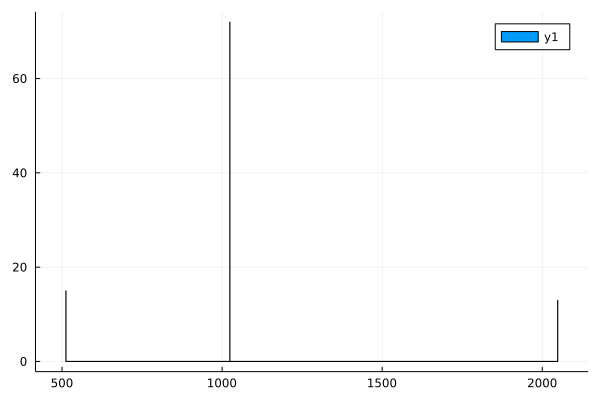

In [134]:
games_results_U9_policy_max_titles = getindex.(games_results_U9_policy, 1)
histogram(games_results_U9_policy_max_titles)

In [136]:
games_results_U9_policy_max_titles = getindex.(games_results_U9_policy, 1)
count(i->i==2048, games_results_U9_policy_max_titles)/size(games_results_U9_policy_max_titles)[1]

0.13

In [ ]:
# Julia Multi-threading often crashed 
#max_tiles8, score8, moveno8 = GM2048.play_game_using_policy_mt(s -> mcts_U8_policy(s), n=100)

In [ ]:
# Julia Multi-threading often crashed 
#max_tiles8, score8, moveno8 = GM2048.play_game_using_policy_mt(s -> mcts_U8_policy(s), n=Threads.nthreads())

In [10]:
mcts_2048_game_U9_policy_2 = play_game(s -> mcts_U9_policy(s))

Move #1, current score=0.0
     0     0     0     0
     0     0     0     0
     0     0     2     0
     0     0     0     2

	a = UP
Move #2, current score=0.0
     0     0     2     2
     0     0     0     0
     0     2     0     0
     0     0     0     0

	a = LEFT
Move #3, current score=4.0
     4     0     0     0
     0     0     0     0
     2     0     0     0
     0     2     0     0

	a = DOWN
Move #4, current score=4.0
     0     0     0     0
     2     0     0     0
     4     0     0     0
     2     2     0     0

	a = LEFT
Move #5, current score=8.0
     0     0     0     0
     2     0     0     0
     4     2     0     0
     4     0     0     0

	a = UP
Move #6, current score=16.0
     2     2     2     0
     8     0     0     0
     0     0     0     0
     0     0     0     0

	a = LEFT
Move #7, current score=20.0
     4     2     4     0
     8     0     0     0
     0     0     0     0
     0     0     0     0

	a = RIGHT
Move #8, current score=20.0
     0 

     0     0     0     2

	a = LEFT
Move #60, current score=512.0
     2     8    64     4
    16    32     2     4
    16     0     0     0
     2     0     0     0

	a = UP
Move #61, current score=552.0
     2     8    64     8
    32    32     2     0
     2     0     0     0
     0     0     2     0

	a = RIGHT
Move #62, current score=616.0
     2     8    64     8
     0     0    64     2
     0     0     0     2
     0     2     0     2

	a = UP
Move #63, current score=748.0
     2     8   128     8
     0     2     4     4
     0     0     0     2
     0     0     0     0

	a = RIGHT
Move #64, current score=756.0
     2     8   128     8
     0     0     2     8
     0     0     2     2
     0     0     0     0

	a = UP
Move #65, current score=776.0
     2     8   128    16
     0     0     4     2
     0     0     0     0
     0     0     4     0

	a = DOWN
Move #66, current score=784.0
     0     0     2     0
     0     0     0     0
     0     0   128    16
     2     8     

    64    64     0     0
     2     4   128     4

	a = RIGHT
Move #119, current score=1476.0
     0     0     0     2
     0     4     4     2
     0     0     0   128
     2     4   128     4

	a = UP
Move #120, current score=1488.0
     2     8     4     4
     0     0   128   128
     0     0     0     4
     0     4     0     0

	a = RIGHT
Move #121, current score=1752.0
     0     2     8     8
     0     0     0   256
     2     0     0     4
     0     0     0     4

	a = RIGHT
Move #122, current score=1768.0
     0     0     2    16
     4     0     0   256
     0     0     2     4
     0     0     0     4

	a = DOWN
Move #123, current score=1780.0
     0     0     0     0
     0     0     0    16
     0     0     0   256
     4     2     4     8

	a = LEFT
Move #124, current score=1780.0
     0     0     0     0
    16     0     0     4
   256     0     0     0
     4     2     4     8

	a = UP
Move #125, current score=1780.0
    16     2     4     4
   256     0     0     8


     0     0     0     4
     0     0     8    16
     4     2   128   256
     0     0     0     4

	a = LEFT
Move #177, current score=2500.0
     4     0     0     2
     8    16     0     0
     4     2   128   256
     4     0     0     0

	a = UP
Move #178, current score=2508.0
     4    16   128     2
     8     2     0   256
     8     0     0     0
     0     0     0     4

	a = UP
Move #179, current score=2524.0
     4    16   128     2
    16     2     0   256
     0     0     0     4
     0     2     0     0

	a = RIGHT
Move #180, current score=2524.0
     4    16   128     2
     0    16     2   256
     0     0     2     4
     0     0     0     2

	a = UP
Move #181, current score=2560.0
     4    32   128     2
     0     2     4   256
     0     0     0     4
     0     0     0     2

	a = LEFT
Move #182, current score=2560.0
     4    32   128     2
     2     4   256     0
     4     0     0     0
     2     0     4     0

	a = UP
Move #183, current score=2560.0
     4

     2   512     8     0
     2    16     8     4

	a = DOWN
Move #235, current score=4028.0
     0     0     0     0
     0     0     0     0
     4   512     2     2
     4    16    16     4

	a = RIGHT
Move #236, current score=4064.0
     0     0     2     0
     0     0     0     0
     0     4   512     4
     0     4    32     4

	a = DOWN
Move #237, current score=4080.0
     0     0     0     0
     2     0     2     0
     0     0   512     0
     0     8    32     8

	a = DOWN
Move #238, current score=4080.0
     0     0     0     0
     0     4     2     0
     0     0   512     0
     2     8    32     8

	a = UP
Move #239, current score=4080.0
     2     4     2     8
     0     8   512     0
     0     0    32     0
     0     2     0     0

	a = DOWN
Move #240, current score=4080.0
     4     0     0     0
     0     4     2     0
     0     8   512     0
     2     2    32     8

	a = LEFT
Move #241, current score=4084.0
     4     0     0     0
     4     2     0     0


	a = LEFT
Move #293, current score=4800.0
     4    32     4     0
     4   128     0     0
   512     4     0     0
     4     2     0     0

	a = UP
Move #294, current score=4808.0
     8    32     4     0
   512   128     0     0
     4     4     2     0
     0     2     0     0

	a = RIGHT
Move #295, current score=4816.0
     0     8    32     4
     0     0   512   128
     0     0     8     2
     4     0     0     2

	a = DOWN
Move #296, current score=4820.0
     0     0     2     0
     0     0    32     4
     0     0   512   128
     4     8     8     4

	a = LEFT
Move #297, current score=4836.0
     2     2     0     0
    32     4     0     0
   512   128     0     0
     4    16     4     0

	a = RIGHT
Move #298, current score=4840.0
     0     0     0     4
     0     0    32     4
     0     2   512   128
     0     4    16     4

	a = UP
Move #299, current score=4848.0
     0     2    32     8
     0     4   512   128
     0     0    16     4
     0     0     2     0

	

     0   256   512     4
     2    16     8     4

	a = DOWN
Move #351, current score=5784.0
     0     2     0     0
     0     0    16     0
     0   256   512     0
     4    16     8     8

	a = RIGHT
Move #352, current score=5800.0
     0     2     0     2
     0     0     0    16
     0     0   256   512
     0     4    16    16

	a = RIGHT
Move #353, current score=5836.0
     0     2     0     4
     0     0     0    16
     0     0   256   512
     0     0     4    32

	a = RIGHT
Move #354, current score=5836.0
     0     0     2     4
     2     0     0    16
     0     0   256   512
     0     0     4    32

	a = UP
Move #355, current score=5836.0
     2     0     2     4
     0     0   256    16
     0     4     4   512
     0     0     0    32

	a = RIGHT
Move #356, current score=5848.0
     0     2     4     4
     0     0   256    16
     0     0     8   512
     0     0     0    32

	a = RIGHT
Move #357, current score=5856.0
     0     0     2     8
     0     0   256   

     2     0     2     0

	a = RIGHT
Move #408, current score=6560.0
     2    32     8     4
   256    16     2   512
     0     0     0   128
     2     0     0     4

	a = RIGHT
Move #409, current score=6560.0
     2    32     8     4
   256    16     2   512
     0     0     0   128
     0     4     2     4

	a = DOWN
Move #410, current score=6564.0
     2     0     0     4
     0    32     0   512
     2    16     8   128
   256     4     4     4

	a = RIGHT
Move #411, current score=6572.0
     0     2     2     4
     0     0    32   512
     2    16     8   128
     0   256     4     8

	a = LEFT
Move #412, current score=6576.0
     4     4     0     0
    32   512     0     4
     2    16     8   128
   256     4     8     0

	a = UP
Move #413, current score=6592.0
     4     4    16     4
    32   512     0   128
     2    16     0     0
   256     4     2     0

	a = DOWN
Move #414, current score=6592.0
     4     4     2     0
    32   512     0     0
     2    16    16     

     4    16   256    16
     0   128     4   128
     0    32   512     8
     0     0     2     2

	a = DOWN
Move #466, current score=7320.0
     0     0   256    16
     0    16     4   128
     2   128   512     8
     4    32     2     2

	a = UP
Move #467, current score=7320.0
     2    16   256    16
     4   128     4   128
     4    32   512     8
     0     0     2     2

	a = UP
Move #468, current score=7328.0
     2    16   256    16
     8   128     4   128
     0    32   512     8
     0     2     2     2

	a = LEFT
Move #469, current score=7332.0
     2    16   256    16
     8   128     4   128
    32   512     8     4
     4     2     0     0

	a = RIGHT
Move #470, current score=7332.0
     2    16   256    16
     8   128     4   128
    32   512     8     4
     2     0     4     2

	a = LEFT
Move #471, current score=7332.0
     2    16   256    16
     8   128     4   128
    32   512     8     4
     2     4     2     2

	a = RIGHT
Move #472, current score=7336.0
 

     4     0     0     0

	a = DOWN
Move #524, current score=9860.0
     4     0     0     0
     2    32     4     0
     8    16  1024   128
     8     8    16     4

	a = RIGHT
Move #525, current score=9876.0
     0     0     0     4
     0     2    32     4
     8    16  1024   128
     2    16    16     4

	a = UP
Move #526, current score=9916.0
     8     2    32     8
     2    32  1024   128
     0     2    16     4
     0     0     0     0

	a = DOWN
Move #527, current score=9916.0
     0     0     0     2
     0     2    32     8
     8    32  1024   128
     2     2    16     4

	a = LEFT
Move #528, current score=9920.0
     2     0     0     0
     2    32     8     0
     8    32  1024   128
     4    16     4     2

	a = UP
Move #529, current score=9988.0
     4    64     8   128
     8    16  1024     2
     4     0     4     0
     0     2     0     0

	a = LEFT
Move #530, current score=9996.0
     4    64     8   128
     8    16  1024     2
     8     2     0     0
  


	a = DOWN
Move #582, current score=10972.0
     0     2     0     0
     0     0    16     2
     8   256  1024     4
     2    64     8     8

	a = RIGHT
Move #583, current score=10988.0
     0     0     2     2
     0     0    16     2
     8   256  1024     4
     0     2    64    16

	a = UP
Move #584, current score=10992.0
     8   256     2     4
     0     2    16     4
     0     0  1024    16
     0     0    64     4

	a = UP
Move #585, current score=11000.0
     8   256     2     8
     0     2    16    16
     0     0  1024     4
     0     0    64     4

	a = RIGHT
Move #586, current score=11032.0
     8   256     2     8
     0     0     2    32
     0     0  1024     4
     0     2    64     4

	a = UP
Move #587, current score=11044.0
     8   256     4     8
     0     2  1024    32
     0     4    64     8
     0     0     0     0

	a = DOWN
Move #588, current score=11044.0
     0     0     0     0
     0   256     4     8
     2     2  1024    32
     8     4    64   


	a = LEFT
Move #640, current score=11696.0
     4   256     2     0
     4   128     8     0
     2    32  1024    32
    32     4     0     0

	a = UP
Move #641, current score=11704.0
     8   256     2    32
     2   128     8     2
    32    32  1024     0
     0     4     0     0

	a = RIGHT
Move #642, current score=11768.0
     8   256     2    32
     2   128     8     2
     0     0    64  1024
     2     0     0     4

	a = DOWN
Move #643, current score=11772.0
     0     0     0    32
     0     2     2     2
     8   256     8  1024
     4   128    64     4

	a = RIGHT
Move #644, current score=11776.0
     0     0     2    32
     0     0     2     4
     8   256     8  1024
     4   128    64     4

	a = DOWN
Move #645, current score=11780.0
     2     0     0    32
     0     0     4     4
     8   256     8  1024
     4   128    64     4

	a = LEFT
Move #646, current score=11788.0
     2    32     0     0
     8     0     2     0
     8   256     8  1024
     4   128    6

  1024   512    16     0

	a = UP
Move #698, current score=13288.0
     2    64    16     2
     4     4     0     0
    32   512     0     0
  1024     2     0     0

	a = LEFT
Move #699, current score=13296.0
     2    64    16     2
     8     0     0     2
    32   512     0     0
  1024     2     0     0

	a = RIGHT
Move #700, current score=13296.0
     2    64    16     2
     0     2     8     2
     0     0    32   512
     0     0  1024     2

	a = DOWN
Move #701, current score=13300.0
     0     0    16     0
     2     0     8     4
     0    64    32   512
     2     2  1024     2

	a = UP
Move #702, current score=13304.0
     4    64    16     4
     0     2     8   512
     0     0    32     2
     0     4  1024     0

	a = DOWN
Move #703, current score=13304.0
     0     2    16     0
     0    64     8     4
     0     2    32   512
     4     4  1024     2

	a = LEFT
Move #704, current score=13312.0
     2    16     0     0
    64     8     4     2
     2    32   512  

	a = DOWN
Move #756, current score=14032.0
    16     0     0     0
     4   128     2     2
     8    64   512     0
     4     4  1024    32

	a = RIGHT
Move #757, current score=14044.0
     0     0     0    16
     0     4   128     4
     0     8    64   512
     2     8  1024    32

	a = DOWN
Move #758, current score=14060.0
     0     0     0    16
     2     0   128     4
     0     4    64   512
     2    16  1024    32

	a = UP
Move #759, current score=14064.0
     4     4   128    16
     0    16    64     4
     0     0  1024   512
     0     0     2    32

	a = LEFT
Move #760, current score=14072.0
     8   128    16     0
    16    64     4     0
  1024   512     0     0
     2    32     0     2

	a = UP
Move #761, current score=14072.0
     8   128    16     2
    16    64     4     0
  1024   512     0     0
     2    32     0     2

	a = DOWN
Move #762, current score=14076.0
     8   128     0     0
    16    64     2     0
  1024   512    16     0
     2    32     4   

┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453


	a = LEFT
Move #810, current score=14692.0
   128     2     8     4
     4  1024    64     2
    16   128     8     0
     8     4   512     4


┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453



	a = RIGHT
Move #811, current score=14692.0
   128     2     8     4
     4  1024    64     2
     4    16   128     8
     8     4   512     4

	a = DOWN
Move #812, current score=14700.0
     4     2     8     4
   128  1024    64     2
     8    16   128     8
     8     4   512     4

	a = UP
Move #813, current score=14716.0
     4     2     8     4
   128  1024    64     2
    16    16   128     8
     4     4   512     4

	a = LEFT
Move #814, current score=14756.0
     4     2     8     4
   128  1024    64     2
    32   128     8     0
     8   512     4     2

	a = DOWN
Move #815, current score=14760.0
     4     2     8     0
   128  1024    64     2
    32   128     8     4
     8   512     4     4

	a = LEFT
Move #816, current score=14768.0
     4     2     8     0
   128  1024    64     2
    32   128     8     4
     8   512     8     2

	a = DOWN
Move #817, current score=14784.0
     4     2     4     0
   128  1024     8     2
    32   128    64     4
     8   512    16

Heuristic MCTS Policy 1: Max title score 

In [16]:
hmcts_policy1 = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    150, # d
    200, # m
    50.0, # c
    s -> score_board(s) # U(s) 
);

In [17]:
hmcts_policy1_game1 = [GM2048.play_game_using_policy(s -> hmcts_policy1(s)) for _ in 1:100]

LoadError: UndefVarError: games_results_U6_policy not defined

In [18]:
max_titles_hmcts_policy1, sum_hmcts_policy1 = getindex.(hmcts_policy1_game1, 1), getindex.(hmcts_policy1_game1, 2)

([512, 1024, 512, 256, 512, 512, 256, 256, 1024, 512  …  1024, 256, 512, 1024, 1024, 256, 512, 1024, 512, 1024], Float32[5972.0, 12032.0, 6548.0, 3240.0, 7064.0, 6784.0, 3420.0, 3068.0, 12168.0, 6064.0  …  13256.0, 3408.0, 6872.0, 10340.0, 10384.0, 3672.0, 5312.0, 11876.0, 5172.0, 10124.0])

In [19]:
count(i->i==2048, max_titles_hmcts_policy1)/size(max_titles_hmcts_policy1)[1]

0.0

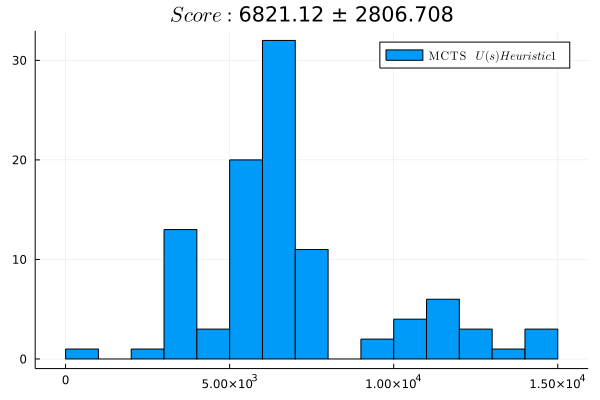

In [20]:
histogram(sum_hmcts_policy1, label=L"\mathrm{MCTS} \quad U(s) Heuristic 1", title=L"Score:" * string(mean(sum_hmcts_policy1)) * " ± " * string(std(sum_hmcts_policy1)))

In [15]:
rollouts_hmcts_policy1 = [ DM.rollout(mdp2048, initial_board(), hmcts_policy1, 1000, isdone) for i in 1:3]
print("mcts_2048_U9_2: $(mean(rollouts_hmcts_policy1)) ± $(std(rollouts_hmcts_policy1))")

mcts_2048_U9_2: 1290.862668921279 ± 48.46837081960683

In [14]:
print("mcts_2048_U9_2: $(mean(rollouts_hmcts_policy1)) ± $(std(rollouts_hmcts_policy1))")

mcts_2048_U9_2: 697.5473012189286 ± 18.818736195780872

In [21]:
function U10(s)
    smoothWeight = 0.1;
    mono2Weight  = 1.0;
    emptyWeight  = 2.7;
    maxWeight    = 2.0;
    SCORE_MONOTONICITY_POWER = 2; 
    
    array = GM2048.bitboard_to_array(s)
    # Heuristic score
    sum = 0;
    empty::Int = 0;
    merges = 0;
    monotonicity_left = 0;
    monotonicity_right = 0;
    monotonicity_up = 0;
    monotonicity_down = 0;

    
    for j in 1:4
        prev = 0;
        counter = 0;
        line = array[j, :]
        for i in 1:4
            rank = line[i];
            sum += rank^SCORE_SUM_POWER;
            if rank == 0 
                empty += 1
            else 
                if (prev == rank) 
                    counter +=1
                elseif (counter > 0) 
                    merges += 1 + counter;
                    counter = 0;
                end
                prev = rank;
            end 
        end 
        
        if (counter > 0) 
            merges += 1 + counter;
        end 

        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_left += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_right += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
    
    for j in 1:4
       line = array[:, j]
        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_up += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_down += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
        
    smoothness = merges
    heuristic_score = 
        smoothness * smoothWeight
       - (min(monotonicity_left, monotonicity_right) + min(monotonicity_up, monotonicity_down) )* mono2Weight
       + log(empty) * emptyWeight
       + score_board(s) * maxWeight
    return heuristic_score
end 

U10 (generic function with 1 method)

In [22]:
mcts_U10_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> U10(s) # U(s) # U
);

In [23]:
mcts_U10_policy_game = play_game(s -> mcts_U10_policy(s))

Move #1, current score=0.0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     2     0     2

	a = UP
Move #2, current score=0.0
     2     2     0     2
     0     0     0     0
     0     0     0     0
     0     0     0     0

	a = RIGHT
Move #3, current score=4.0
     0     0     2     4
     0     0     0     0
     0     4     0     0
     0     0     0     0

	a = RIGHT
Move #4, current score=4.0
     0     0     2     4
     0     0     0     0
     0     0     0     4
     0     0     2     0

	a = UP
Move #5, current score=16.0
     0     0     4     8
     0     0     0     0
     0     0     0     0
     2     0     0     0

	a = RIGHT
Move #6, current score=16.0
     0     0     4     8
     0     0     0     0
     0     4     0     0
     0     0     0     2

	a = UP
Move #7, current score=16.0
     0     4     4     8
     0     0     0     2
     0     0     0     2
     0     0     0     0

	a = RIGHT
Move #8, current score=24.0
     

     8    64    32     0
     8    16     4     2

	a = UP
Move #61, current score=508.0
     2     2     4     2
     4    64    32     0
    16    16     4     2
     0     0     0     0

	a = LEFT
Move #62, current score=544.0
     4     4     2     0
     4    64    32     0
    32     4     2     0
     0     0     2     0

	a = UP
Move #63, current score=556.0
     8     4     2     0
    32    64    32     0
     0     4     4     0
     0     2     0     0

	a = LEFT
Move #64, current score=564.0
     8     4     2     0
    32    64    32     0
     8     0     0     0
     2     4     0     0

	a = RIGHT
Move #65, current score=564.0
     0     8     4     2
     4    32    64    32
     0     0     0     8
     0     0     2     4

	a = LEFT
Move #66, current score=564.0
     8     4     2     2
     4    32    64    32
     8     0     0     0
     2     4     0     0

	a = RIGHT
Move #67, current score=568.0
     0     8     4     4
     4    32    64    32
     0     2   

     0     2     0     0
     2     4     4     8
     2     2   256     2

	a = LEFT
Move #120, current score=1744.0
     0     2     0     0
     2     0     0     0
     2     8     8     0
     4   256     2     0

	a = RIGHT
Move #121, current score=1760.0
     0     4     0     2
     0     0     0     2
     0     0     2    16
     0     4   256     2

	a = DOWN
Move #122, current score=1772.0
     0     0     0     0
     0     0     0     4
     2     0     2    16
     0     8   256     2

	a = LEFT
Move #123, current score=1776.0
     2     0     0     0
     4     0     0     0
     4    16     0     0
     8   256     2     0

	a = DOWN
Move #124, current score=1784.0
     0     0     0     0
     2     2     0     0
     8    16     0     0
     8   256     2     0

	a = UP
Move #125, current score=1800.0
     2     2     2     2
    16    16     0     0
     0   256     0     0
     0     0     0     0

	a = LEFT
Move #126, current score=1840.0
     4     4     0     0


     8   256     8     0
     0     2     2     0

	a = RIGHT
Move #178, current score=2376.0
    64     4     2     4
     0     0    16    64
     0     8   256     8
     0     0     2     4

	a = LEFT
Move #179, current score=2376.0
    64     4     2     4
    16    64     2     0
     8   256     8     0
     2     4     0     0

	a = UP
Move #180, current score=2380.0
    64     4     4     4
    16    64     8     0
     8   256     0     0
     2     4     2     0

	a = RIGHT
Move #181, current score=2388.0
     0    64     4     8
     0    16    64     8
     0     0     8   256
     4     2     4     2

	a = DOWN
Move #182, current score=2404.0
     0     0     4     2
     0    64    64    16
     0    16     8   256
     4     2     4     2

	a = LEFT
Move #183, current score=2532.0
     4     2     0     2
   128    16     0     0
    16     8   256     0
     4     2     4     2

	a = DOWN
Move #184, current score=2536.0
     4     2     0     0
   128    16     0     0

	a = DOWN
Move #236, current score=4064.0
     0     0     2     0
     4     0     0     0
     8   512     0     0
    32     2     4     4

	a = RIGHT
Move #237, current score=4072.0
     0     2     0     2
     0     0     0     4
     0     0     8   512
     0    32     2     8

	a = RIGHT
Move #238, current score=4076.0
     0     0     4     4
     0     0     0     4
     0     0     8   512
     0    32     2     8

	a = UP
Move #239, current score=4084.0
     0    32     4     8
     0     0     8   512
     0     0     2     8
     0     2     0     0

	a = RIGHT
Move #240, current score=4084.0
     0    32     4     8
     0     2     8   512
     0     0     2     8
     0     0     0     2

	a = DOWN
Move #241, current score=4084.0
     2     0     0     8
     0     0     4   512
     0    32     8     8
     0     2     2     2

	a = DOWN
Move #242, current score=4084.0
     0     0     2     8
     0     0     4   512
     0    32     8     8
     2     2     2     2

   512   128     2     0
     2     8     8     0
     8     2     2     4

	a = LEFT
Move #295, current score=4820.0
     4    32     2     0
   512   128     2     0
     2    16     2     0
     8     4     4     0

	a = LEFT
Move #296, current score=4828.0
     4    32     2     0
   512   128     2     0
     2    16     2     0
     8     8     0     2

	a = RIGHT
Move #297, current score=4844.0
     0     4    32     2
     4   512   128     2
     0     2    16     2
     0     0    16     2

	a = UP
Move #298, current score=4884.0
     4     4    32     4
     0   512   128     4
     0     2    32     0
     0     2     0     0

	a = RIGHT
Move #299, current score=4892.0
     0     8    32     4
     0   512   128     4
     0     2     2    32
     0     0     0     2

	a = UP
Move #300, current score=4900.0
     0     8    32     8
     0   512   128    32
     0     2     2     2
     2     0     0     0

	a = RIGHT
Move #301, current score=4904.0
     0     8    32     8


     0     0    16     4
     2     2   512   256
     0     0    32     8

	a = DOWN
Move #353, current score=5872.0
     0     0     0     2
     2     0    32     4
     0     4   512   256
     2     2    32     8

	a = RIGHT
Move #354, current score=5876.0
     0     0     0     2
     2     2    32     4
     0     4   512   256
     0     4    32     8

	a = UP
Move #355, current score=5884.0
     2     2    32     2
     0     8   512     4
     4     0    32   256
     0     0     0     8

	a = UP
Move #356, current score=5884.0
     2     2    32     2
     4     8   512     4
     0     2    32   256
     0     0     0     8

	a = LEFT
Move #357, current score=5888.0
     4    32     2     0
     4     8   512     4
     2    32   256     2
     8     0     0     0

	a = DOWN
Move #358, current score=5896.0
     0     0     0     2
     8    32     2     0
     2     8   512     4
     8    32   256     2

	a = RIGHT
Move #359, current score=5896.0
     0     2     0     2
 

    16     2     0     0

	a = LEFT
Move #412, current score=6708.0
   512     8     0     0
    64     8     2     2
     2   256   128     0
    16     2     0     0

	a = UP
Move #413, current score=6724.0
   512    16     2     2
    64   256   128     0
     2     2     2     0
    16     0     0     0

	a = LEFT
Move #414, current score=6732.0
   512    16     4     2
    64   256   128     0
     4     2     0     0
    16     0     0     0

	a = RIGHT
Move #415, current score=6732.0
   512    16     4     2
     0    64   256   128
     0     0     4     2
     0     0     2    16

	a = LEFT
Move #416, current score=6732.0
   512    16     4     2
    64   256   128     2
     4     2     0     0
     2    16     0     0

	a = UP
Move #417, current score=6736.0
   512    16     4     4
    64   256   128     0
     4     2     0     0
     2    16     2     0

	a = UP
Move #418, current score=6736.0
   512    16     4     4
    64   256   128     0
     4     2     2     4
    

	a = LEFT
Move #471, current score=9200.0
     8     2    32    16
    32    16  1024     8
     4     2     2     0
     0     0     0     0

	a = RIGHT
Move #472, current score=9204.0
     8     2    32    16
    32    16  1024     8
     0     0     4     4
     0     2     0     0

	a = RIGHT
Move #473, current score=9212.0
     8     2    32    16
    32    16  1024     8
     0     0     2     8
     0     0     0     2

	a = UP
Move #474, current score=9228.0
     8     2    32    16
    32    16  1024    16
     2     0     2     2
     0     0     0     0

	a = UP
Move #475, current score=9260.0
     8     2    32    32
    32    16  1024     2
     2     0     2     0
     2     0     0     0

	a = RIGHT
Move #476, current score=9328.0
     0     8     2    64
    32    16  1024     2
     0     0     0     4
     0     4     0     2

	a = UP
Move #477, current score=9328.0
    32     8     2    64
     0    16  1024     2
     0     4     0     4
     0     2     0     2

	a

  1024     8     2     0
     4     8    32   128
     4    64     8     0

	a = UP
Move #529, current score=10060.0
     2    16     2   128
  1024    64    32     0
     8     0     8     0
     0     2     0     0

	a = LEFT
Move #530, current score=10076.0
     2    16     2   128
  1024    64    32     4
    16     0     0     0
     2     0     0     0

	a = DOWN
Move #531, current score=10076.0
     2     0     0     0
  1024     0     2     0
    16    16     2   128
     2    64    32     4

	a = LEFT
Move #532, current score=10108.0
     2     0     2     0
  1024     2     0     0
    32     2   128     0
     2    64    32     4

	a = UP
Move #533, current score=10112.0
     2     4     2     4
  1024    64   128     0
    32     2    32     0
     2     0     0     0

	a = DOWN
Move #534, current score=10112.0
     2     2     0     0
  1024     4     2     0
    32    64   128     0
     2     2    32     4

	a = LEFT
Move #535, current score=10120.0
     4     2     0   


	a = RIGHT
Move #586, current score=11096.0
     0     8     2    64
     0   256  1024    32
     0     2     4     2
     2     0     0    32

	a = LEFT
Move #587, current score=11096.0
     8     2    64     0
   256  1024    32     2
     2     4     2     0
     2    32     0     0

	a = UP
Move #588, current score=11100.0
     8     2    64     2
   256  1024    32     2
     4     4     2     0
     0    32     0     0

	a = RIGHT
Move #589, current score=11108.0
     8     2    64     2
   256  1024    32     2
     2     0     8     2
     0     0     0    32

	a = RIGHT
Move #590, current score=11108.0
     8     2    64     2
   256  1024    32     2
     0     2     8     2
     2     0     0    32

	a = UP
Move #591, current score=11112.0
     8     2    64     4
   256  1024    32     2
     2     2     8    32
     0     2     0     0

	a = LEFT
Move #592, current score=11116.0
     8     2    64     4
   256  1024    32     2
     4     8    32     0
     2     2     0

	a = DOWN
Move #645, current score=11856.0
     0    64     2     0
     2   128  1024     2
    32    32    16     8
     2   256     4     2

	a = LEFT
Move #646, current score=11920.0
    64     2     4     0
     2   128  1024     2
    64    16     8     0
     2   256     4     2

	a = DOWN
Move #647, current score=11924.0
    64     2     4     0
     2   128  1024     2
    64    16     8     0
     2   256     4     4

	a = LEFT
Move #648, current score=11932.0
    64     2     4     0
     2   128  1024     2
    64    16     8     0
     2   256     8     4

	a = UP
Move #649, current score=11948.0
    64     2     4     2
     2   128  1024     4
    64    16    16     2
     2   256     0     0

	a = LEFT
Move #650, current score=11980.0
    64     2     4     2
     2   128  1024     4
    64    32     2     0
     2   256     0     2

	a = RIGHT
Move #651, current score=11980.0
    64     2     4     2
     2   128  1024     4
     0    64    32     2
     2     2   256 

     8    32    64    32
     0     4  1024    16
     0     2     8     2

	a = LEFT
Move #703, current score=13372.0
     2     8   512     2
     8    32    64    32
     4  1024    16     0
     2     8     2     0

	a = RIGHT
Move #704, current score=13372.0
     2     8   512     2
     8    32    64    32
     2     4  1024    16
     0     2     8     2

	a = DOWN
Move #705, current score=13372.0
     2     8   512     2
     2    32    64    32
     8     4  1024    16
     2     2     8     2

	a = RIGHT
Move #706, current score=13376.0
     2     8   512     2
     2    32    64    32
     8     4  1024    16
     2     4     8     2

	a = DOWN
Move #707, current score=13388.0
     2     0   512     2
     4     8    64    32
     8    32  1024    16
     2     8     8     2

	a = RIGHT
Move #708, current score=13404.0
     2     2   512     2
     4     8    64    32
     8    32  1024    16
     0     2    16     2

	a = LEFT
Move #709, current score=13408.0
     4   512  

     4  1024     8     8
    64    64     2   128
     0   512    32     0
     0     2     8     4

	a = RIGHT
Move #761, current score=14372.0
     2     4  1024    16
     0   128     2   128
     0     0   512    32
     0     2     8     4

	a = DOWN
Move #762, current score=14372.0
     2     0  1024    16
     0     4     2   128
     0   128   512    32
     2     2     8     4

	a = UP
Move #763, current score=14376.0
     4     4  1024    16
     0   128     2   128
     2     2   512    32
     0     0     8     4

	a = UP
Move #764, current score=14376.0
     4     4  1024    16
     2   128     2   128
     0     2   512    32
     2     0     8     4

	a = RIGHT
Move #765, current score=14384.0
     0     8  1024    16
     2   128     2   128
     0     2   512    32
     2     2     8     4

	a = DOWN
Move #766, current score=14392.0
     0     0  1024    16
     0     8     2   128
     2   128   512    32
     4     4     8     4

	a = RIGHT
Move #767, current score=1

	a = DOWN
Move #818, current score=15308.0
     2  1024     2    16
     8    16   128     2
     4     4   512     8
     2     2   256     4

	a = LEFT
Move #819, current score=15320.0
     2  1024     2    16
     8    16   128     2
     8   512     8     0
     4   256     4     2

	a = UP
Move #820, current score=15340.0
     2  1024     2    16
    16    16   128     4
     4   512     8     0
     2   256     4     0

	a = DOWN
Move #821, current score=15340.0
     2  1024     2     4
    16    16   128     0
     4   512     8    16
     2   256     4     4

	a = LEFT
Move #822, current score=15380.0
     2  1024     2     4
    32   128     0     2
     4   512     8    16
     2   256     8     0

	a = DOWN
Move #823, current score=15396.0
     2  1024     0     0
    32   128     2     4
     4   512     2     2
     2   256    16    16

	a = RIGHT
Move #824, current score=15432.0
     0     0     2  1024
    32   128     2     4
     2     4   512     4
     0     2   256 

	a = RIGHT
Move #876, current score=15984.0
    64   128     2     8
     2    16    32  1024
     0   256    64     4
     0     2   512     4

	a = DOWN
Move #877, current score=15992.0
     0   128     2     4
     0    16    32     8
    64   256    64  1024
     2     2   512     8

	a = RIGHT
Move #878, current score=15996.0
     0   128     2     4
     2    16    32     8
    64   256    64  1024
     0     4   512     8

	a = LEFT
Move #879, current score=15996.0
   128     2     4     2
     2    16    32     8
    64   256    64  1024
     4   512     8     0

	a = DOWN
Move #880, current score=15996.0
   128     2     4     2
     2    16    32     2
    64   256    64     8
     4   512     8  1024

	a = UP
Move #881, current score=16000.0
   128     2     4     4
     2    16    32     8
    64   256    64  1024
     4   512     8     2

	a = RIGHT
Move #882, current score=16008.0
     2   128     2     8
     2    16    32     8
    64   256    64  1024
     4   512     

┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453


	a = DOWN
Move #889, current score=16064.0
     4     4   128     4
     2    16    32    16
    64   256    64  1024
     4     2   512    16



┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453


	a = DOWN
Move #889, current score=16064.0
     4     4   128     4
     2    16    32    16
    64   256    64  1024
     4     2   512    16



┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453


	a = DOWN
Move #889, current score=16064.0
     4     4   128     4
     2    16    32    16
    64   256    64  1024
     4     2   512    16


┌ Warning: Illegal move!
└ @ DecisionMakingProblems C:\Users\chuachen\.julia\packages\DecisionMakingProblems\1SSR6\src\mdp\2048.jl:453



	a = RIGHT
Move #890, current score=16072.0
     2     8   128     4
     2    16    32    16
    64   256    64  1024
     4     2   512    16

	a = DOWN
     2     8   128     4
     4    16    32    16
    64   256    64  1024
     4     2   512    16


Game over. Your score is 16076. The highest rank you achieved was 10.


In [24]:
games_results_U10_policy = [GM2048.play_game_using_policy(s -> mcts_U10_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (512, 6956.0, 443)
 (2048, 25448.0, 1227)
 (512, 6576.0, 424)
 (2048, 26864.0, 1318)
 (512, 6248.0, 394)
 (1024, 12372.0, 716)
 (1024, 14416.0, 786)
 (2048, 22740.0, 1069)
 (1024, 15024.0, 803)
 (512, 7096.0, 456)
 (1024, 15872.0, 876)
 (1024, 14448.0, 792)
 (512, 7288.0, 474)
 ⋮
 (1024, 14448.0, 796)
 (1024, 14288.0, 787)
 (512, 6376.0, 410)
 (1024, 15116.0, 820)
 (1024, 12020.0, 681)
 (1024, 11936.0, 660)
 (1024, 15936.0, 889)
 (1024, 14216.0, 780)
 (1024, 12208.0, 687)
 (1024, 11892.0, 660)
 (1024, 15864.0, 873)
 (1024, 15876.0, 875)

In [26]:
max_titles_U10_policy, sum_U10_policy = getindex.(games_results_U10_policy, 1), getindex.(games_results_U10_policy, 2)
count(i->i==2048, max_titles_U10_policy)/size(max_titles_U10_policy)[1]

0.15

In [30]:
histogram(max_titles_U10_policy, label=L"\mathrm{MCTS} \quad U(s) Heuristic 10", title=L"Max Tile Score:" * string(mean(max_titles_U10_policy)) * " ± " * string(std(max_titles_U10_policy)))

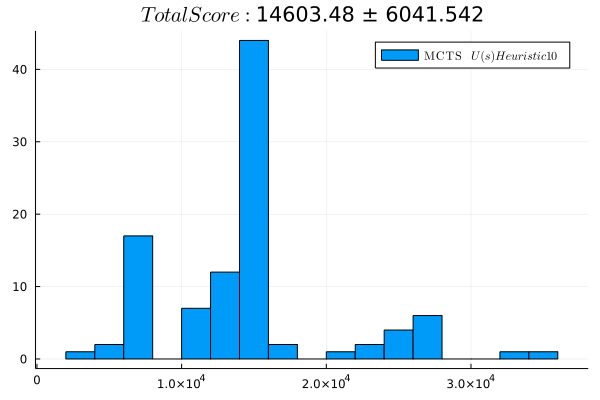

In [32]:
histogram(sum_U10_policy, label=L"\mathrm{MCTS} \quad U(s) Heuristic 10", title=L"Total Score:" * string(mean(sum_U10_policy)) * " ± " * string(std(sum_U10_policy)))

In [33]:
mcts_U10_policy2 = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    500, # d
    300, # m
    50.0, # c
    s -> U10(s) # U(s) # U
);

In [34]:
games_results_U10_policy2 = [GM2048.play_game_using_policy(s -> mcts_U10_policy2(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (1024, 14264.0, 778)
 (1024, 16000.0, 891)
 (512, 6984.0, 450)
 (1024, 12288.0, 698)
 (1024, 12640.0, 707)
 (512, 7520.0, 492)
 (2048, 26972.0, 1307)
 (2048, 25324.0, 1234)
 (2048, 31396.0, 1490)
 (1024, 15920.0, 886)
 (1024, 12444.0, 703)
 (1024, 15244.0, 822)
 (2048, 26848.0, 1311)
 ⋮
 (512, 7156.0, 456)
 (2048, 26784.0, 1312)
 (1024, 16884.0, 936)
 (1024, 15444.0, 848)
 (512, 7492.0, 456)
 (512, 6964.0, 447)
 (512, 7296.0, 479)
 (1024, 13884.0, 738)
 (1024, 16080.0, 894)
 (1024, 12272.0, 685)
 (512, 7012.0, 453)
 (1024, 12024.0, 677)

In [35]:
max_titles_U10_policy2, sum_U10_policy2 = getindex.(games_results_U10_policy2, 1), getindex.(games_results_U10_policy2, 2)
count(i->i==2048, max_titles_U10_policy2)/size(max_titles_U10_policy2)[1]

0.13

In [36]:
function U11(s)
    smoothWeight = 0.1;
    mono2Weight  = 1.0;
    emptyWeight  = 2.7;
    maxWeight    = 1.0;
    SCORE_MONOTONICITY_POWER = 1; # 4.0
    SCORE_SUM_POWER = 2;  # 3.5 

    
    array = GM2048.bitboard_to_array(s)
    # Heuristic score
    sum = 0;
    empty::Int = 0;
    merges = 0;
    monotonicity_left = 0;
    monotonicity_right = 0;
    monotonicity_up = 0;
    monotonicity_down = 0;

    
    for j in 1:4
        prev = 0;
        counter = 0;
        line = array[j, :]
        for i in 1:4
            rank = line[i];
            sum += rank^SCORE_SUM_POWER;
            if rank == 0 
                empty += 1
            else 
                if (prev == rank) 
                    counter +=1
                elseif (counter > 0) 
                    merges += 1 + counter;
                    counter = 0;
                end
                prev = rank;
            end 
        end 
        
        if (counter > 0) 
            merges += 1 + counter;
        end 

        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_left += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_right += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
    
    for j in 1:4
       line = array[:, j]
        for i  in 2:4
            if (line[i-1] > line[i]) 
                monotonicity_up += line[i-1] ^ SCORE_MONOTONICITY_POWER - line[i] ^ SCORE_MONOTONICITY_POWER;
            else 
                monotonicity_down += line[i] ^ SCORE_MONOTONICITY_POWER - line[i-1] ^ SCORE_MONOTONICITY_POWER;
            end
        end    
    end 
        
    smoothness = merges
    heuristic_score = 
        smoothness * smoothWeight
       - (min(monotonicity_left, monotonicity_right) - min(monotonicity_up, monotonicity_down) )* mono2Weight
       + log(empty) * emptyWeight
       + score_board(s) * maxWeight
    return heuristic_score
end 

U11 (generic function with 1 method)

In [37]:
mcts_U11_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> U11(s) # U(s) # U
);

In [40]:
include("./GM2048.jl")
mcts_2048_game_U11_policy = GM2048.play_game_using_policy(s -> mcts_U11_policy(s), show_board=true)

     2    32     8     2
     4  1024   512    64
     2    64     2     4
    32   128    16     2



(1024, 14380.0f0, 780)

In [43]:
games_results_U11_policy = [GM2048.play_game_using_policy(s -> mcts_U11_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (1024, 15332.0, 841)
 (1024, 11884.0, 656)
 (1024, 15824.0, 871)
 (1024, 15656.0, 856)
 (1024, 15104.0, 807)
 (1024, 15256.0, 834)
 (2048, 26916.0, 1330)
 (2048, 26560.0, 1291)
 (1024, 15860.0, 870)
 (1024, 15444.0, 853)
 (1024, 16012.0, 877)
 (1024, 11888.0, 662)
 (1024, 16752.0, 938)
 ⋮
 (1024, 15804.0, 864)
 (1024, 15264.0, 839)
 (2048, 33204.0, 1577)
 (2048, 25168.0, 1210)
 (2048, 26844.0, 1308)
 (1024, 15580.0, 850)
 (1024, 13504.0, 731)
 (1024, 15268.0, 836)
 (512, 6968.0, 446)
 (2048, 30256.0, 1419)
 (1024, 15964.0, 871)
 (2048, 26748.0, 1295)

In [44]:
max_titles_U11_policy, sum_U11_policy = getindex.(games_results_U11_policy, 1), getindex.(games_results_U11_policy, 2)
count(i->i==2048, max_titles_U11_policy)/size(max_titles_U11_policy)[1]

0.17

In [45]:
rollouts_mcts_U11 = [ DM.rollout(mdp2048, initial_board(), mcts_U11_policy, 1000, isdone) for i in 1:100 ]

100-element Vector{Float64}:
 1403.4137369779446
 1424.7104173873875
 1404.5325442476817
 1388.8204528416036
 1429.3055169352158
 1446.8878994189486
 1357.8199974645358
 1455.0663934905974
 1388.6300943726308
 1305.6469580381415
 1437.654908489719
 1398.9927165658657
 1413.68885426346
    ⋮
 1392.3657474573392
 1370.6656161085905
 1464.807341775947
 1466.4604688617515
 1348.7698648705814
 1367.6297738887154
 1318.6069015717621
 1458.0701190054663
 1408.0406356379938
 1392.1449070812157
 1374.8930700801832
 1411.7558255811382

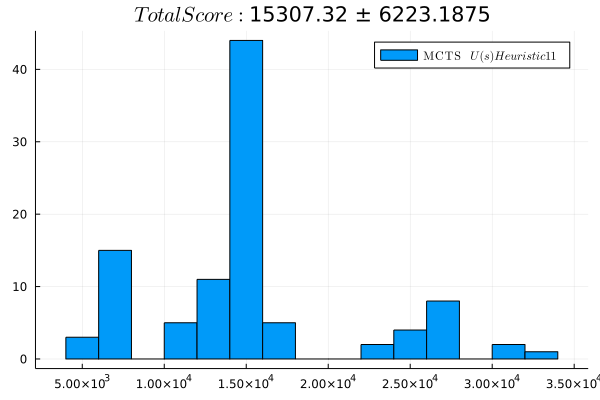

In [46]:
histogram(sum_U11_policy, label=L"\mathrm{MCTS} \quad U(s) Heuristic 11", title=L"Total Score:" * string(mean(sum_U11_policy)) * " ± " * string(std(sum_U11_policy)))

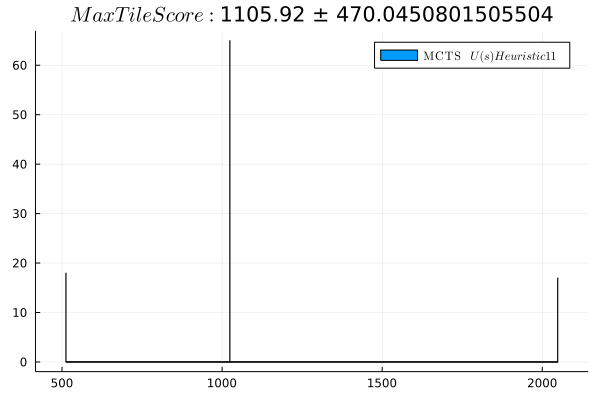

In [47]:
histogram(max_titles_U11_policy, label=L"\mathrm{MCTS} \quad U(s) Heuristic 11", title=L"Max Tile Score:" * string(mean(max_titles_U11_policy)) * " ± " * string(std(max_titles_U11_policy)))

In [67]:
GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.1, mono2Weight  = 1.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 1)


2.8853900817779268

In [83]:
include("./GM2048.jl")
mcts_U12_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.1, mono2Weight  = 1.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 1) # U(s) # U
);

In [84]:
mcts_2048_game_U12_policy = GM2048.play_game_using_policy(s -> mcts_U12_policy(s), show_board=true)

     0     4    16     8
    32   128  1024     2
    16   256    64   512
     2     4    32     8



(1024, 15900.0f0, 881)

In [85]:
maximum(max_titles_U11_policy)

2048

In [86]:
games_results_U12_policy = [GM2048.play_game_using_policy(s -> mcts_U12_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (512, 7680.0, 503)
 (1024, 15848.0, 881)
 (1024, 15424.0, 858)
 (1024, 16840.0, 936)
 (1024, 12092.0, 668)
 (1024, 16596.0, 929)
 (1024, 15828.0, 875)
 (1024, 10492.0, 587)
 (2048, 25908.0, 1225)
 (2048, 23068.0, 1091)
 (1024, 12112.0, 687)
 (1024, 14172.0, 768)
 (1024, 12304.0, 693)
 ⋮
 (512, 6944.0, 448)
 (1024, 15384.0, 839)
 (1024, 14140.0, 771)
 (512, 6684.0, 419)
 (1024, 15144.0, 821)
 (1024, 15856.0, 871)
 (2048, 23560.0, 1136)
 (1024, 13964.0, 739)
 (1024, 16524.0, 916)
 (1024, 12200.0, 678)
 (512, 7480.0, 489)
 (512, 7068.0, 463)

In [87]:
max_titles_U12_policy, sum_U12_policy = getindex.(games_results_U12_policy, 1), getindex.(games_results_U12_policy, 2)
count(i->i==2048, max_titles_U12_policy)/size(max_titles_U12_policy)[1]

0.17

In [89]:
mcts_U13_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.1, mono2Weight  = 2.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 1) # U(s) # U
);

In [90]:
mcts_2048_game_U13_policy = GM2048.play_game_using_policy(s -> mcts_U13_policy(s), show_board=true)

     4     8    64     2
     2   128    32    16
    32    16  1024     8
     8   512     4     2



(1024, 14172.0f0, 770)

In [91]:
games_results_U13_policy = [GM2048.play_game_using_policy(s -> mcts_U13_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (1024, 13112.0, 713)
 (1024, 15896.0, 876)
 (1024, 15948.0, 867)
 (1024, 14480.0, 800)
 (1024, 15760.0, 862)
 (1024, 11912.0, 665)
 (512, 6428.0, 418)
 (1024, 11952.0, 672)
 (1024, 15328.0, 834)
 (512, 6968.0, 445)
 (1024, 16124.0, 894)
 (512, 6944.0, 448)
 (1024, 15932.0, 894)
 ⋮
 (1024, 15868.0, 877)
 (1024, 12216.0, 693)
 (1024, 14976.0, 797)
 (2048, 25296.0, 1222)
 (1024, 15816.0, 865)
 (1024, 15728.0, 850)
 (2048, 26456.0, 1282)
 (1024, 15824.0, 876)
 (512, 7096.0, 454)
 (512, 7280.0, 460)
 (1024, 16140.0, 902)
 (2048, 26888.0, 1325)

In [92]:
max_titles_U13_policy, sum_U13_policy = getindex.(games_results_U13_policy, 1), getindex.(games_results_U13_policy, 2)
count(i->i==2048, max_titles_U13_policy)/size(max_titles_U13_policy)[1]

0.17

In [94]:
mcts_U14_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.5, mono2Weight  = 1.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 1) # U(s) # U
);

In [95]:
mcts_2048_game_U14_policy = GM2048.play_game_using_policy(s -> mcts_U14_policy(s), show_board=true)

     4   128    16     4
    16    64  1024     2
     4    32    16    32
   512     4     2     8



(1024, 14228.0f0, 781)

In [96]:
games_results_U14_policy = [GM2048.play_game_using_policy(s -> mcts_U14_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (1024, 15860.0, 872)
 (512, 7076.0, 458)
 (1024, 15840.0, 872)
 (1024, 15972.0, 890)
 (1024, 15140.0, 815)
 (1024, 15504.0, 842)
 (256, 3224.0, 247)
 (512, 6768.0, 435)
 (1024, 15116.0, 818)
 (512, 6760.0, 437)
 (1024, 15740.0, 858)
 (1024, 12080.0, 678)
 (1024, 15780.0, 856)
 ⋮
 (1024, 14292.0, 772)
 (1024, 14316.0, 779)
 (1024, 16048.0, 886)
 (1024, 16060.0, 901)
 (1024, 11964.0, 666)
 (2048, 35340.0, 1688)
 (1024, 11868.0, 660)
 (2048, 26088.0, 1254)
 (512, 7040.0, 458)
 (1024, 15516.0, 855)
 (1024, 11800.0, 655)
 (1024, 16092.0, 901)

In [97]:
max_titles_U14_policy, sum_U14_policy = getindex.(games_results_U14_policy, 1), getindex.(games_results_U14_policy, 2)
count(i->i==2048, max_titles_U14_policy)/size(max_titles_U14_policy)[1]

0.13

In [98]:
mcts_U15_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    50.0, # c
    s -> GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.05, mono2Weight  = 1.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 1) # U(s) # U
);

In [99]:
mcts_2048_game_U15_policy = GM2048.play_game_using_policy(s -> mcts_U15_policy(s), show_board=true)

     2  1024     8     4
    32    64   512     2
     8    16    32    16
     4     2     4     2



(1024, 13472.0f0, 725)

In [100]:
games_results_U15_policy = [GM2048.play_game_using_policy(s -> mcts_U15_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (512, 6728.0, 429)
 (1024, 15596.0, 851)
 (1024, 14868.0, 814)
 (1024, 12196.0, 680)
 (2048, 32184.0, 1533)
 (1024, 13756.0, 734)
 (1024, 15892.0, 880)
 (512, 7040.0, 458)
 (1024, 15548.0, 860)
 (1024, 12160.0, 680)
 (512, 7728.0, 506)
 (1024, 12056.0, 667)
 (1024, 14488.0, 801)
 ⋮
 (1024, 15412.0, 839)
 (512, 7208.0, 470)
 (1024, 15080.0, 816)
 (1024, 15856.0, 871)
 (1024, 15244.0, 830)
 (1024, 12192.0, 687)
 (1024, 14404.0, 798)
 (1024, 15916.0, 878)
 (1024, 14196.0, 777)
 (1024, 14084.0, 759)
 (512, 7408.0, 472)
 (1024, 15752.0, 861)

In [101]:
max_titles_U15_policy, sum_U15_policy = getindex.(games_results_U15_policy, 1), getindex.(games_results_U15_policy, 2)
count(i->i==2048, max_titles_U15_policy)/size(max_titles_U15_policy)[1]

0.09

In [116]:
mcts_U16_policy = DM.MonteCarloTreeSearch(
    mdp2048, # 𝒫
    Dict{Tuple{UInt64, UInt8}, Float64}(), # Q
    Dict{Tuple{UInt64, UInt8}, Float64}(), # N
    100, # d
    300, # m
    10.0, # c
    s -> GM2048.HeuristicScore(s; maxWeight = 1.0, mergeWeight = 0.1, mono2Weight  = 5.0, emptyWeight  = 2.7, sum_pow = 2, mono2power= 2) # U(s) # U
);

In [117]:
mcts_2048_game_U16_policy = GM2048.play_game_using_policy(s -> mcts_U16_policy(s), show_board=true)

     2    32     2     4
     8   128   512    32
    16    32    64     2
     2     2    16   256



(512, 7072.0f0, 452)

In [106]:
games_results_U16_policy = [GM2048.play_game_using_policy(s -> mcts_U16_policy(s)) for _ in 1:100]

100-element Vector{Tuple{Int64, Float32, Int64}}:
 (512, 6100.0, 384)
 (512, 5756.0, 382)
 (128, 1176.0, 125)
 (256, 3036.0, 233)
 (1024, 15896.0, 884)
 (512, 6920.0, 446)
 (512, 7124.0, 449)
 (512, 6628.0, 442)
 (512, 7004.0, 451)
 (512, 6028.0, 387)
 (512, 7040.0, 448)
 (1024, 13484.0, 726)
 (1024, 12808.0, 731)
 ⋮
 (512, 7240.0, 466)
 (1024, 15932.0, 889)
 (1024, 10648.0, 602)
 (512, 7168.0, 461)
 (512, 6972.0, 447)
 (512, 6360.0, 406)
 (512, 7020.0, 454)
 (1024, 11112.0, 600)
 (256, 3300.0, 261)
 (512, 5500.0, 364)
 (512, 7100.0, 453)
 (512, 6796.0, 433)

In [107]:
max_titles_U16_policy, sum_U16_policy = getindex.(games_results_U16_policy, 1), getindex.(games_results_U16_policy, 2)
count(i->i==2048, max_titles_U16_policy)/size(max_titles_U16_policy)[1]

0.01

In [124]:
win_2048_rate, max_scores, sum_scores = GM2048.PlayGames_with_HeuristicMCTS(n=100) 

(0.13, [1024, 512, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 2048  …  512, 2048, 1024, 1024, 1024, 1024, 512, 512, 1024, 1024], Float32[12328.0, 7180.0, 15420.0, 26140.0, 14828.0, 15144.0, 12224.0, 13720.0, 15624.0, 26708.0  …  7332.0, 25012.0, 14808.0, 15092.0, 12084.0, 12016.0, 7336.0, 7520.0, 15524.0, 14132.0])

In [125]:
win_2048_rate

0.13